In [ ]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# Other globals
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

--2024-03-24 04:02:58--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-03-24 04:02:58--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  6.86MB/s    in 1.8s    

2024-03-24 04:03:01 (6.86 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



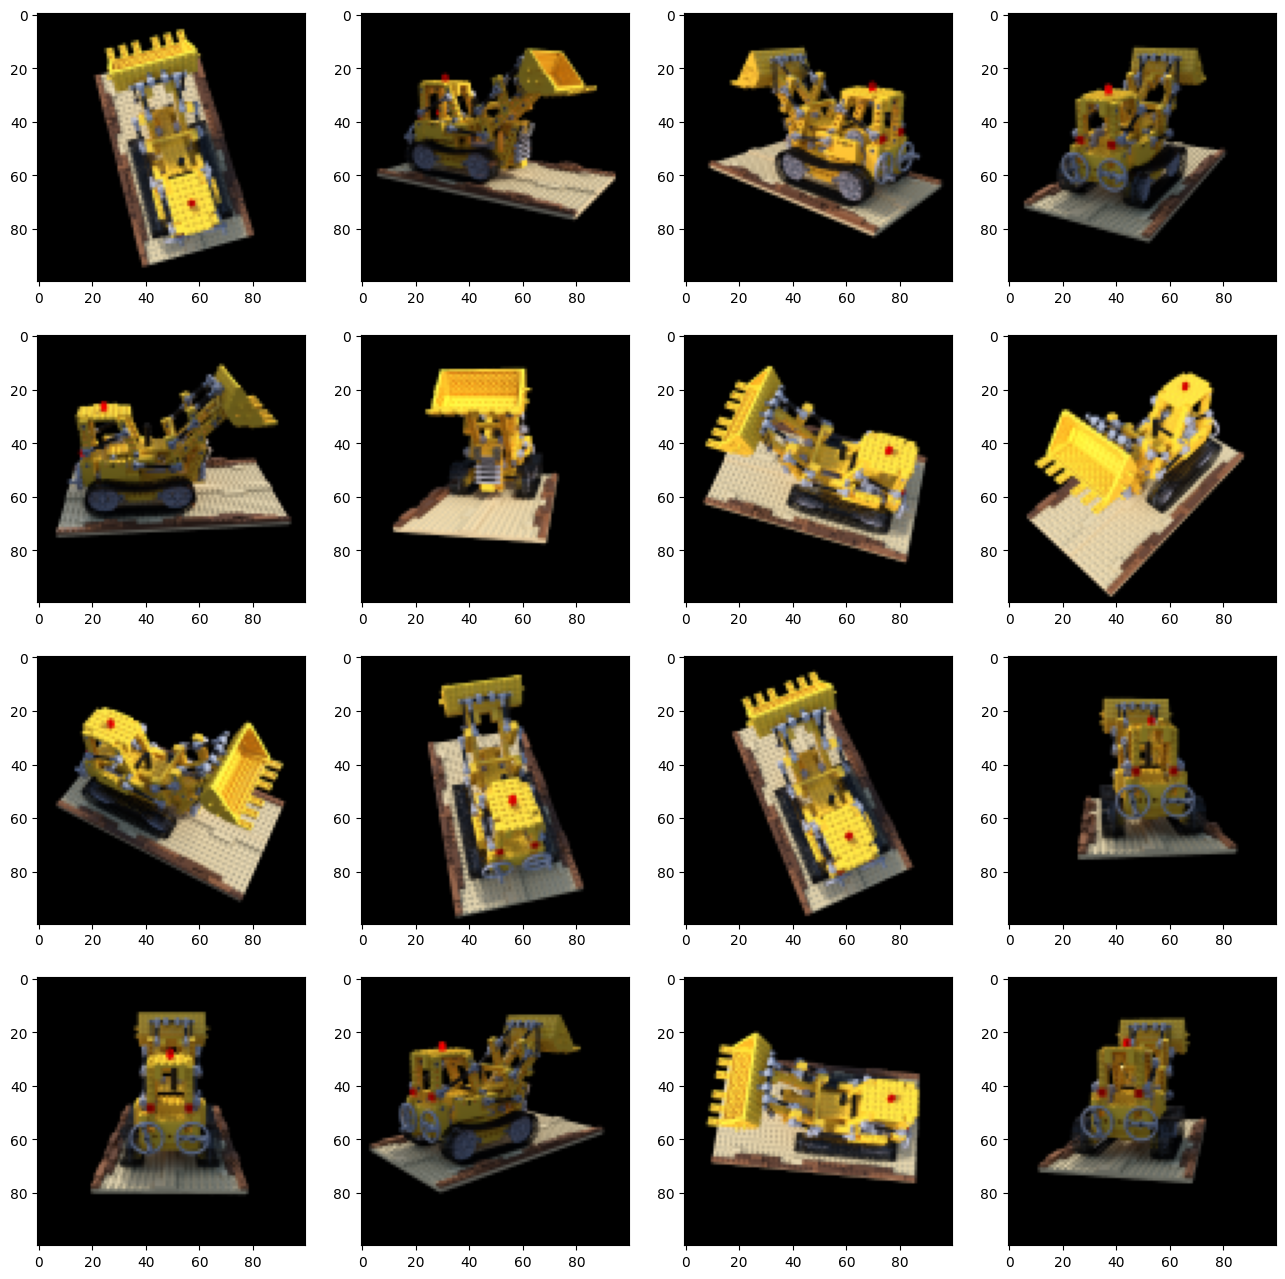

In [ ]:
# Load dataset
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')

# Visualize images in dataset
num_images = data['images'].shape[0]
random_indices = np.random.choice(num_images, size=16, replace=False)
fig = plt.figure(figsize=(16,16))
for i in range(1, len(random_indices)+1):
  fig.add_subplot(4,4,i)
  plt.imshow(data["images"][random_indices[i-1]])

In [ ]:
# Convert data to tensors

# Hold one image for test
images = data['images']
test_image = images[101]
test_image = torch.from_numpy(test_image).to(device)
images = torch.from_numpy(images[:100,]).to(device)

poses = data['poses']
poses = torch.from_numpy(poses).to(device)
test_pose = poses[101]

focal_length = data['focal']
focal_length = torch.from_numpy(focal_length).to(device)

height, width = images.shape[1:3] # TODO: isn't it width, height?

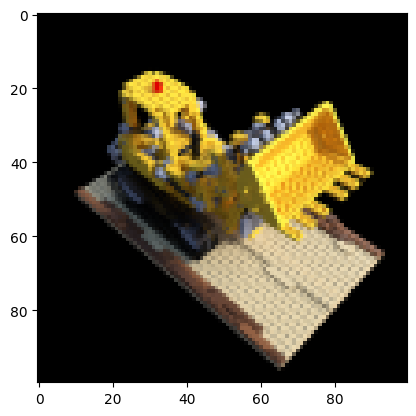

In [ ]:
# Visualize test image
plt.imshow(test_image.detach().cpu().numpy())

In [ ]:
# Compute directions and origins for rays for all pixels in the image.
# Both will be of shape  h x w x 3
def get_raybundle_for_img(height: int, width: int, focal_length: float, tf_cam2world: torch.Tensor):

  # Create a meshgrid for the image pixels
  pixel_coors_along_w = torch.arange(width)
  pixel_coors_along_h = torch.arange(height)
  wcoor_grid_pixel = pixel_coors_along_w.expand(height,-1).to(device)
  hcoor_grid_pixel = pixel_coors_along_h.view(-1,1).expand(-1, width).to(device)

  # Compute ray directions extending from optical center to 3d world for every pixel.
  # This is basically expressing pixel coordinates in world frame.
  wcoor_grid_cam = (wcoor_grid_pixel - (width/2))/ focal_length
  hcoor_grid_cam = -1*(hcoor_grid_pixel - (height/2))/ focal_length
  pixel_coors_cam = torch.stack([wcoor_grid_cam, hcoor_grid_cam, -torch.ones_like(wcoor_grid_cam)], dim=-1)

  # To convert cam to world frame, 3x3 rotation matrix of pose must be multiplied by column vector of each point.
  # We have hxwx3 matrix. Write down the multiplication for one element and you'll know how to implement it.
  pixel_coors_world = torch.sum(pixel_coors_cam[..., None, :] * tf_cam2world[:3, :3], dim=-1)
  ray_directions_world = pixel_coors_world

  ray_origins_world = tf_cam2world[:3,-1].expand(pixel_coors_world.shape)

  return ray_origins_world, ray_directions_world

In [ ]:
# Converts world coordinates to Normalized Device coordinates so that in forward-facing captures the scene can be bounded.
# In world space, you will sample depth values between n and f, where f=infinity in forward-facing scenes.
# In ndc space, you will instead sample depth values between n and 1. After shifting origin to near plane, you can sample depth values between 0 and 1.
def tf_world2ndc(ray_origins_world, ray_directions_world, near, width, height, focal_length):
  # Shift ray origins to near plane
  depths = -(near + ray_origins_world[..., 2])/ ray_directions_world[..., 2]
  ray_origins_world = ray_origins_world + depths[..., None] * ray_directions_world # TODO- check why None

  # Project from world to ndc space
  o_x = (-focal_length * ray_origins_world[...,0]) / ((width/2.)*ray_origins_world[...,2])
  o_y = (-focal_length * ray_origins_world[...,1]) / ((height/2.)*ray_origins_world[...,2])
  o_z = ((2.0*focal_length) + ray_origins_world[...,2]) / (ray_origins_world[...,2])
  d_x = (-focal_length / (width/2.0)) * ((ray_directions_world[...,0]/ray_directions_world[...,2])-(ray_origins_world[...,0]/ray_origins_world[...,2]))
  d_y = (-focal_length / (height/2.0)) * ((ray_directions_world[...,1]/ray_directions_world[...,2])-(ray_origins_world[...,1]/ray_origins_world[...,2]))
  d_z = (-2.0 * focal_length) / (ray_origins_world[...,2])

  ray_origins_ndc = torch.stack([o_x, o_y, o_z], -1)
  ray_directions_ndc = torch.stack([d_x, d_y, d_z], -1)
  return ray_origins_ndc, ray_directions_ndc

In [ ]:
# Do inverse tranform sampling- https://en.wikipedia.org/wiki/Inverse_transform_sampling
def sample_pdf(bins, weights, num_samples, sample_randomly):

  # Calculate PDF. Divide by sum to get them between 0 and 1.
  weights = weights + 1e-5
  pdf = weights/weights.sum(-1).unsqueeze(-1)

  # Compute CDF for all bins starting from 0 to 1
  cdf = torch.cumsum(pdf, dim=-1)
  cdf = torch.cat((torch.zeros_like(cdf[...,:1]), cdf), dim=-1)

  # Generate samples from standard uniform distribution deterministically or randomly
  if sample_randomly:
    samples_uniform = torch.rand(list(cdf.shape[:-1])+[num_samples]).to(weights)
  else:
    samples_uniform = torch.linspace(0., 1., num_samples).to(weights)
    samples_uniform = samples_uniform.expand(list(cdf.shape[:-1])+[num_samples])

  # Find indices where cdf value is just above the sampled value
  indices = torch.searchsorted(cdf, samples_uniform, side='right')

  # Ensure they are within the range of possible indices and find the indices that are right below and above these
  below_indices = torch.max(torch.zeros_like(indices-1), indices-1)
  above_indices = torch.min((cdf.shape[-1]-1) * torch.ones_like(indices) , indices)

  # Find the respective cdf values and the bin values
  cdf_for_below_indices = torch.gather(cdf, -1, below_indices)
  bin_for_below_indices = torch.gather(bins, -1, below_indices)
  cdf_for_above_indices = torch.gather(cdf, -1, above_indices)
  bin_for_above_indices = torch.gather(bins, -1, above_indices)

  # Find denom and ensure numerical stability during division
  denom = cdf_for_above_indices - cdf_for_below_indices
  denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)

  # Find interpolation weights
  # If sample_uniform is close to below index, then interpolation weight will be close to 0.
  interpolation_weights = (samples_uniform - cdf_for_below_indices)/denom

  # Perform linear interpolation
  # if interpolation weight = 0, then below will be chosen.
  # if interpolation weight = 1, then above bin will be chosen.
  # if interpolation weight is between 0 and 1, linear interpolation.
  samples_cdf = bin_for_below_indices + (interpolation_weights * (bin_for_above_indices-bin_for_below_indices))

  return samples_cdf




In [ ]:
# TO ADD IN SCRIPT
def get_params_of_gaussian_cone_coors(depth_values, cone_radii):
    t0 = depth_values[..., :-1]
    t1 = depth_values[..., 1:]
    cone_radii = cone_radii.unsqueeze(dim=-1)
    mu = (t0 + t1) / 2
    hw = (t1 - t0) / 2
    t_mean = mu + (2 * mu * hw**2) / (3 * mu**2 + hw**2)
    t_var = (hw**2) / 3 - (4 / 15) * ((hw**4 * (12 * mu**2 - hw**2)) /
                                        (3 * mu**2 + hw**2)**2)
    r_var = cone_radii**2 * ((mu**2) / 4 + (5 / 12) * hw**2 - 4 / 15 *
                                (hw**4) / (3 * mu**2 + hw**2))
    return t_mean, t_var, r_var

In [ ]:
# TO ADD IN SCRIPT
def get_params_of_gaussian_world_coors(mu_t, sigma_t, sigma_r, ray_origins, ray_directions):
    means = ray_origins[...,None,:] + mu_t[...,None]*ray_directions[...,None,:]

    dir_mag_sq =  torch.sum(ray_directions ** 2, dim=-1).unsqueeze(dim=-1)
    covars = ( sigma_t[...,None] * ((ray_directions ** 2)[...,None,:]) + \
    (sigma_r[...,None] * (1. - (ray_directions ** 2)/dir_mag_sq)[...,None,:]) )

    return means, covars

In [ ]:
def sample_points_mip(ray_directions, ray_origins, depth_values, cone_radii):
    # sample_points = ray_origins[...,None,:] + (ray_directions[...,None,:] * depth_values[...,:,None])
    mu_t, sigma_t, sigma_r = get_params_of_gaussian_cone_coors(depth_values, cone_radii)
    means, covars  = get_params_of_gaussian_world_coors(mu_t, sigma_t, sigma_r, ray_origins, ray_directions) # chunk * num_encoding * 3

    return means, covars

In [ ]:
# TO ADD IN SCRIPT
# Sample 3D points and their depth values on the ray bundle
# sampled 3d points will be of shape h x w x num_samples x 3 and depth_values will be of shape h x w x num_samples
# TODO: t_values vs depth_values?
def get_coarse_depth_values_mip(ray_directions: torch.Tensor, ray_origins: torch.Tensor, nearThresh: float, farThresh: float, \
                                num_points: int, linear_disparity):
  t_values = torch.linspace(0., 1., num_points+1).to(device) # (num_points)
  if linear_disparity:
    z_values = 1. / (1. / nearThresh * (1. - t_values) + 1. / farThresh * t_values)
  else:
    z_values = nearThresh * (1. - t_values) + farThresh * t_values
  z_values = z_values.expand([ray_directions.shape[0], num_points+1])


  # Randomize depth values
  mids = 0.5 * (z_values[..., 1:] + z_values[..., :-1])
  upper = torch.cat((mids, z_values[..., -1:]), dim=-1)
  lower = torch.cat((z_values[..., :1], mids), dim=-1)
  t_rand = torch.rand(z_values.shape).to(device)
  depth_values = lower + (upper - lower) * t_rand

  return depth_values

In [ ]:
def sample_coarse_points(ray_directions: torch.Tensor, ray_origins: torch.Tensor, nearThresh: float, farThresh: float, \
                        num_points: int, linear_disparity):
  t_values = torch.linspace(0., 1., num_points).to(device) # (num_points)
  if linear_disparity:
    z_values = 1. / (1. / nearThresh * (1. - t_values) + 1. / farThresh * t_values)
  else:
    z_values = nearThresh * (1. - t_values) + farThresh * t_values
  z_values = z_values.expand([ray_directions.shape[0], num_points])


  # Randomize depth values
  mids = 0.5 * (z_values[..., 1:] + z_values[..., :-1])
  upper = torch.cat((mids, z_values[..., -1:]), dim=-1)
  lower = torch.cat((z_values[..., :1], mids), dim=-1)
  t_rand = torch.rand(z_values.shape).to(device)
  depth_values = lower + (upper - lower) * t_rand

  sample_points = ray_origins[...,None,:] + (ray_directions[...,None,:] * depth_values[...,:,None])
  return depth_values, sample_points

In [ ]:
# Perform positional encoding on a tensor to get a high-dimensional representation enabling better capture of high frequency variations and
# to capture the relationship between tensor values.
# encoding is of shape (h * w * num_samples, 3 +(2 * num_encoding_functions * 3))
def positional_encoding(tensor: torch.Tensor, num_encoding_functions: int, include_input: bool):
  if include_input:
    encoding = [tensor] # (h * w * num_samples, 3)
  else:
    encoding = []

  frequency_band = torch.linspace(
        2.0 ** 0.0,
        2.0 ** (num_encoding_functions - 1),
        num_encoding_functions,
        dtype=tensor.dtype,
        device=tensor.device,
  )
  for frequency in frequency_band:
    for func in [torch.sin, torch.cos]:
      sinusoidal_component = func(tensor * frequency)
      encoding.append(sinusoidal_component)

  return torch.cat(encoding, dim=-1) # x,y,z, sin(x), cos(x), sin(2x), cos(2x).....cos((2^num)*x)

In [ ]:
# TO ADD IN SCRIPT
# mu_tensor is of shape (h * w * num_samples,3)
# diag_sigma_tensor is of shape (h * w * num_samples, ???)
def integrated_positional_encoding(mu_tensor: torch.Tensor, diag_sigma_tensor: torch.tensor, num_encoding_functions: int):
    encoding = []

    frequency_matrixx =  torch.cat([2**i * torch.eye(3) for i in range(0,num_encoding_functions)], dim=-1).to(device) # P matriX
    # print("Mu_tensor :",mu_tensor.shape)
    # print("diag_sigma_tensor :",diag_sigma_tensor.shape)
    mu_pe = torch.matmul(mu_tensor, frequency_matrixx)**2 # shape: batch x num_encoding x 18
    # print(mu_tensor.shape, diag_sigma_tensor.shape, frequency_matrix.shape, mu_pe.shape)
    mu_pe = torch.cat((mu_pe, mu_pe + 0.5 * torch.pi), -1)

    diag_sigma_pe = torch.matmul(diag_sigma_tensor, frequency_matrixx)**2
    diag_sigma_pe = torch.cat((diag_sigma_pe, diag_sigma_pe), -1)
    # print(diag_sigma_pe.shape)

    encoding.append(torch.sin(mu_pe) * torch.exp(-0.5*diag_sigma_pe))
    # encoding.append(torch.cos(mu_pe) * torch.exp(-0.5*diag_sigma_pe)) # TODO : CHECK IF ADDING THIS HELPS
    # print(pe1.shape, pe2.shape)
    return torch.cat(encoding, dim=-1)





In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, min_deg, max_deg):
        super(PositionalEncoding, self).__init__()
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.scales = nn.Parameter(torch.tensor([2 ** i for i in range(min_deg, max_deg)]), requires_grad=False).to(device)

    def forward(self, x, y=None):
        # x = x.to(device)
        # y = y.to(device)
        shape = list(x.shape[:-1]) + [-1]
        x_enc = (x[..., None, :] * self.scales[:, None]).reshape(shape)
        x_enc = torch.cat((x_enc, x_enc + 0.5 * torch.pi), -1)
        if y is not None:
            # IPE
            y_enc = (y[..., None, :] * self.scales[:, None]**2).reshape(shape)
            y_enc = torch.cat((y_enc, y_enc), -1)
            x_ret = torch.exp(-0.5 * y_enc) * torch.sin(x_enc)
            y_ret = torch.maximum(torch.zeros_like(y_enc), 0.5 * (1 - torch.exp(-2 * y_enc) * torch.cos(2 * x_enc)) - x_ret ** 2)
            return x_ret, y_ret
        else:
            # PE
            x_ret = torch.sin(x_enc)
            return x_ret

positional_encoding_obj = PositionalEncoding(0, 16)
viewdirs_encoding_obj = PositionalEncoding(0,4)

In [ ]:
# Define model architecture.
# Input is of shape - (h * w * num_samples, (2 * num_posencoding_functions * 3)+(2 * num_direncoding_functions * 3))
# Output is of shape - (h * w * num_samples, 4) where the 4-dim vector represents the RGB information and density of that respective 3D sample point.
class NeRF(nn.Module):

  def __init__(self, num_encoding_pos, num_encoding_dir, use_viewdirs):
    super(NeRF, self).__init__()
    self.num_layers = 5
    self.skip_layer = 4
    self.filter_size = 128
    self.output_size = 4
    self.use_viewdirs = use_viewdirs
    self.input_pos_dim = 2 * num_encoding_pos * 3
    self.input_dir_dim = 2 * num_encoding_dir * 3

    self.fc_layers = nn.ModuleList()
    self.fc_layers.append(nn.Linear(self.input_pos_dim, self.filter_size))
    for layer in range(self.num_layers-1):
      # Skip - Adding residual connection
      if layer == self.skip_layer-1:
        self.fc_layers.append(nn.Linear(self.input_pos_dim + self.filter_size, self.filter_size))
      else:
        self.fc_layers.append(nn.Linear(self.filter_size, self.filter_size))

    if self.use_viewdirs:
      self.alpha_layer = nn.Linear(self.filter_size, 1)

      self.fc_dir1_layer = nn.Linear(self.filter_size, self.filter_size)
      self.fc_dir2_layer = nn.Linear(self.input_dir_dim + self.filter_size, self.filter_size//2)
      # self.rgb_layer = nn.Linear(filter_size//2, filter_size//2)
      self.rgb_layer = nn.Linear(self.filter_size//2, self.output_size-1)
    else:
      self.out_layer = nn.Linear(self.filter_size, self.output_size)

  def forward(self, x):
    # TODO: isn't input 6D? why are they saying 5D?
    input_pos, input_dir = x[...,:self.input_pos_dim], x[..., self.input_pos_dim:]
    x = input_pos
    for i, layer in enumerate(self.fc_layers):
      # print(i, layer)
      if i == self.skip_layer:
        # print(x.shape, input_pos.shape)
        x = self.fc_layers[i](torch.cat((input_pos, x), dim=-1))
      else:
        x = self.fc_layers[i](x)
      x = nn.functional.relu(x)

    if self.use_viewdirs:
      alpha = self.alpha_layer(x)
      feature = self.fc_dir1_layer(x)
      x = self.fc_dir2_layer(torch.cat((input_dir, feature), dim=-1))
      x = nn.functional.relu(x) # TODO: Isn't this sigmoid in paper
      rgb = self.rgb_layer(x)
      x = torch.cat((rgb, alpha), dim=-1)
    else:
      x = self.out_layer(x)

    return x

In [ ]:
NeRF(6,6,True)

NeRF(
  (fc_layers): ModuleList(
    (0): Linear(in_features=36, out_features=128, bias=True)
    (1-3): 3 x Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=164, out_features=128, bias=True)
  )
  (alpha_layer): Linear(in_features=128, out_features=1, bias=True)
  (fc_dir1_layer): Linear(in_features=128, out_features=128, bias=True)
  (fc_dir2_layer): Linear(in_features=164, out_features=64, bias=True)
  (rgb_layer): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
# TO ADD IN SCRIPT
# Input is of shape (chunk_size x num_samples x 4)
# Output is of shape (chunk_size x 3)
# TODO: Add diagramatic explanation for understanding
def render_image_batch_from_3dinfo(rgb_density: torch.Tensor, depth_values: torch.Tensor, use_white_bkgd: bool):

  # Normalize RGB values to the range 0 to 1 and since density (opacity/ amount of light absorbed/ absorption coeff) is non-negative, apply relu activation.
  rgb_values = torch.sigmoid(rgb_density[..., :3]) # (chunk_size x num_samples x 3)
  density_values = torch.nn.functional.relu(rgb_density[..., 3])

  # print(rgb_values.shape, density_values.shape)

  # Compute consecutive difference between depth values, i.e distance of every segment sampled in 3D space
  dist_values = depth_values[...,1:]-depth_values[...,:-1]

  # For the last segment i.e between the last sampled point and ray end, distance is unbounded. So to make it tractable, we add last segment distance to a large value.
  one_e10 = torch.tensor([1e10], dtype=depth_values.dtype, device=depth_values.device).expand(depth_values[..., :1].shape)
  # dist_values = torch.cat([dist_values, one_e10], dim=-1) # (h x w x num_samples)
  # print(dist_values.shape)
  # Compute cumulative transmittance along every segment (complement of absorption, i.e amount of light trasmitted through medium after absorption)

  transmittance_values = 1. - torch.exp(-density_values * dist_values)
  num_stability_val = 1e-10
  cum_transmittance_values = transmittance_values * cumprod_exclusive(1. - transmittance_values + num_stability_val) # (h x w x num_samples)
  # TODO: why 1-transmittance values

  # Render RGB map i.e RGB image
  rgb_map = (cum_transmittance_values[..., None] * rgb_values).sum(dim=-2) # (h x w x 3)
  # Compute cum trasnmittance for image
  accumulated_transmittance_map = cum_transmittance_values.sum(dim=-1)

  # Render depth map i.e. depth image # TODO CHECK
  t_mids = 0.5 * (depth_values[..., :-1] + depth_values[..., 1:])
  distance = (cum_transmittance_values * t_mids).sum(dim=-1) / accumulated_transmittance_map
  depth_map = torch.clamp(torch.nan_to_num(distance), depth_values[:, 0], depth_values[:, -1])
  # depth_map = (cum_transmittance_values * depth_values).sum(dim=-1) # (h x w x 1)



  # White background
  if use_white_bkgd:
    rgb_map = rgb_map + (1. - accumulated_transmittance_map[...,None])

  # Disparity Map
  disp_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / accumulated_transmittance_map)

  return rgb_map, disp_map, accumulated_transmittance_map, depth_map, cum_transmittance_values



In [ ]:
def cumprod_exclusive(tensor: torch.Tensor):

  # for input (a,b,c), cumprod_inclusive is (a, a*b, a*b*c)
  cumprod_inclusive = torch.cumprod(tensor, dim=-1)

  # for input (a,b,c), cumprod_exclusive is (1, a, a*b)
  cumprod_exclusive = torch.roll(cumprod_inclusive, 1, dims=-1) # (a*b*c, a, a*b)
  cumprod_exclusive[..., 0] = 1.

  return cumprod_exclusive

In [ ]:
def get_chunks(tensor: torch.Tensor, chunk_size: int):
  chunks = [tensor[i:i+chunk_size] for i in range(0, tensor.shape[0], chunk_size)]
  return chunks

In [ ]:
# TO ADD IN SCRIPT
def get_radiance_field_per_chunk_mip(mu_tensor, diag_sigma_tensor, model, num_pos_encoding_functions, include_input_in_posenc, use_viewdirs,
								 viewdirs_batch, num_dir_encoding_functions, include_input_in_direnc, chunk_size):

		# Encode sample points using integrated positional embedding
		encoded_sample_points = integrated_positional_encoding(mu_tensor, diag_sigma_tensor, num_pos_encoding_functions)
		# encoded_sample_points = positional_encoding_obj(mu_tensor, diag_sigma_tensor)[0]
		encoded_sample_points = encoded_sample_points.reshape(-1, encoded_sample_points.shape[-1])
		# print(encoded_sample_points.shape)

		if use_viewdirs:
				ipdirs_batch = viewdirs_batch[...,None,:].expand(mu_tensor.shape) # h*w,num,3
				ipdirs_batch = ipdirs_batch.reshape(-1, 3) # h*w*num, 3
				# encoded_dirs = viewdirs_encoding_obj(ipdirs_batch.to(device))
				encoded_dirs = positional_encoding(ipdirs_batch, num_dir_encoding_functions, include_input_in_direnc)
				# print(encoded_dirs.shape)
				encoded_sample_points = torch.cat((encoded_sample_points, encoded_dirs), dim=-1)

		# print(encoded_sample_points.shape)
		# Batchify
		ip_chunks = get_chunks(encoded_sample_points, chunk_size)
		rgba_batch = []
		for chunk in ip_chunks:
			rgba_batch.append(model(chunk.to(device)))

		rgba_batch = torch.cat(rgba_batch, dim=0)
		rgba_batch = rgba_batch.reshape(list(mu_tensor.shape[:-1]) + [rgba_batch.shape[-1]])
		return rgba_batch

In [ ]:
def get_radiance_field_per_chunk(sample_points, model, num_pos_encoding_functions, include_input_in_posenc, use_viewdirs,
								 viewdirs_batch, num_dir_encoding_functions, include_input_in_direnc, chunk_size):

		# Flatten sample points
		flattened_sample_points = sample_points.view(-1,3) # h*w*num, 3

		# Encode sample points using positional embedding
		encoded_sample_points = positional_encoding(flattened_sample_points, num_pos_encoding_functions, include_input_in_posenc)
		if use_viewdirs:
				ipdirs_batch = viewdirs_batch[...,None,:].expand(sample_points.shape) # h*w,num,3
				ipdirs_batch = ipdirs_batch.reshape(-1, 3) # h*w*num, 3
				encoded_dirs = positional_encoding(ipdirs_batch, num_dir_encoding_functions, include_input_in_direnc)
				encoded_sample_points_batch = torch.cat((encoded_sample_points, encoded_dirs), dim=-1)

		# Batchify
		ip_chunks = get_chunks(encoded_sample_points_batch, chunk_size)
		rgba_batch = []
		for chunk in ip_chunks:
			rgba_batch.append(model(chunk.to(device)))

		rgba_batch = torch.cat(rgba_batch, dim=0)
		rgba_batch = rgba_batch.reshape(list(sample_points.shape[:-1]) + [rgba_batch.shape[-1]])
		return rgba_batch

In [ ]:
# TO ADD IN SCRIPT
def run_nerf_mip(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, use_white_bkgd,
             near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
             include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
             num_dir_encoding_functions, model, chunk_size, num_random_rays, mode):

    if mode == 'train':
        model.train()
    else:
        model.eval()

    ray_origins, ray_directions = get_raybundle_for_img(height, width, focal_length, training_campose)

    if use_viewdirs: # TODO: check benefit of this
        view_dirs = ray_directions / ray_directions.norm(p=2, dim=-1).unsqueeze(-1)
        view_dirs = view_dirs.view(-1, 3)

    if is_ndc_required:
        ray_origins, ray_directions = tf_world2ndc(ray_origins, ray_directions, near_thresh, height, width, focal_length)

    # print(ray_directions[:,:-1,:].shape, ray_directions[:,1:,:].shape)
    # print(torch.sum(((ray_directions[:,:-1,:] - ray_directions[:,1:,:]) ** 2), dim=2).shape)
    # Euclidean distance between each direction vector and its right neigbor along x axis except last ray, left neighbor
    dx = torch.sqrt(torch.sum(((ray_directions[:,:-1,:] - ray_directions[:,1:,:]) ** 2), dim=2))
    dx = torch.concat((dx, dx[:, -2:-1]), dim=-1)
    cone_radii = dx * 2/ np.sqrt(12) # shape: height x width

    # Flatten and concatenate
    ray_origins = ray_origins.view(-1, 3)
    ray_directions = ray_directions.view(-1, 3) # h*w, 3
    cone_radii = cone_radii.view(-1, 1)

    # # Randomly sample rays for OOM error
    # random_indices = []
    # if mode=='train' and num_random_rays > 0:
    #   random_indices = np.random.choice(ray_directions.shape[0], size=(num_random_rays), replace=False)
    #   ray_directions = ray_directions[random_indices, :] # num_rand_rays x 3
    #   ray_origins = ray_origins[random_indices, : ] # num_rand_rays x 3
    #   if use_viewdirs:
    #       view_dirs = view_dirs[random_indices, : ]

    near_points = near_thresh * torch.ones_like(ray_directions[...,:1])
    far_points = far_thresh * torch.ones_like(ray_directions[...,:1]) # h*w, 1 or num_random_rays, 1
    concatenated_rays = torch.cat((ray_origins, ray_directions, near_points, far_points, cone_radii), dim=-1)
    if use_viewdirs:
        concatenated_rays = torch.cat((concatenated_rays, view_dirs), dim=-1) # h*w, 11 or or num_random_rays, 11

    # Batchify
    chunks = get_chunks(concatenated_rays, chunk_size)
    rgb_map_coarse_list = []
    rgb_map_fine_list = []
    for chunk in chunks:
        ray_origins_batch, ray_directions_batch = chunk[...,:3], chunk[...,3:6]
        near_points_batch, far_points_batch, cone_radii_batch = chunk[...,6], chunk[...,7], chunk[...,8]
        if use_viewdirs:
            viewdirs_batch = chunk[..., 9:] # h*w, 3

        # Stratified Sampling for generating coarse points

        coarse_depth_values = get_coarse_depth_values_mip(ray_directions_batch, ray_origins_batch,
                                                                        near_thresh, far_thresh, num_coarse_samples_per_ray,
                                                                        is_ndc_required)
        coarse_sample_means, coarse_sample_covs = sample_points_mip(ray_directions_batch, ray_origins_batch, coarse_depth_values, cone_radii_batch)
        # print(coarse_depth_values.shape, coarse_sample_means.shape, coarse_sample_covs.shape)
        rgba_coarse = get_radiance_field_per_chunk_mip(coarse_sample_means,coarse_sample_covs, model_coarse, num_pos_encoding_functions,
                                              include_input_in_posenc, use_viewdirs, viewdirs_batch,
                                              num_dir_encoding_functions, include_input_in_direnc, chunk_size)
        # print(rgba_coarse.shape)
        # TODO: 1. Check extra arguments - white_bckgd, noise
        # TODO: 2. shud we mutiply by ray_directions ?
        rgb_map_coarse, disp_map_coarse, acc_map_coarse, depth_map_coarse, weights = render_image_batch_from_3dinfo(rgba_coarse , coarse_depth_values, use_white_bkgd)
        rgb_map_coarse_list.append(rgb_map_coarse)

        # Fine - Hierachical Sampling
        if num_fine_samples_per_ray > 0:
            # TODO: Check everything from here ??????
            depth_values_mid = .5 * (coarse_depth_values[..., 1:] + coarse_depth_values[..., :-1])
            z_samples = sample_pdf(depth_values_mid, weights[..., 1:-1], num_fine_samples_per_ray, True)
            z_samples = z_samples.detach()

            fine_depth_values, _ = torch.sort(torch.cat((coarse_depth_values, z_samples), dim=-1), dim=-1)
            fine_sample_means, fine_sample_covs = sample_points_mip(ray_directions_batch, ray_origins_batch, fine_depth_values, cone_radii_batch)

            rgba_fine = get_radiance_field_per_chunk_mip(fine_sample_means,fine_sample_covs, model_fine, num_pos_encoding_functions,
                                              include_input_in_posenc, use_viewdirs, viewdirs_batch,
                                              num_dir_encoding_functions, include_input_in_direnc, chunk_size)
            rgb_map_fine, disp_map_fine, acc_map_fine, depth_map_fine, _ = render_image_batch_from_3dinfo(rgba_fine , fine_depth_values, use_white_bkgd)
            rgb_map_fine_list.append(rgb_map_fine)

    rgb_coarse_image = torch.cat(rgb_map_coarse_list, dim=0)
    rgb_fine_image = torch.cat(rgb_map_fine_list, dim=0)

    return rgb_coarse_image, rgb_fine_image


In [ ]:
def run_nerf(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, use_white_bkgd,
             near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
             include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
             num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode):

	if mode == 'train':
		model_fine.train()
		model_coarse.train()
	else:
		model_fine.eval()
		model_coarse.eval()

	ray_origins, ray_directions = get_raybundle_for_img(height, width, focal_length, training_campose)

	if use_viewdirs: # TODO: check benefit of this
		view_dirs = ray_directions / ray_directions.norm(p=2, dim=-1).unsqueeze(-1)
		view_dirs = view_dirs.view(-1, 3)

	if is_ndc_required:
		ray_origins, ray_directions = tf_world2ndc(ray_origins, ray_directions, near_thresh, height, width, focal_length)

	# Flatten and concatenate
	ray_origins = ray_origins.view(-1, 3)
	ray_directions = ray_directions.view(-1, 3) # h*w, 3

	# Randomly sample rays for OOM error
	random_indices = []
	if mode=='train' and num_random_rays > 0:
		random_indices = np.random.choice(ray_directions.shape[0], size=(num_random_rays), replace=False)
		ray_directions = ray_directions[random_indices, :] # num_rand_rays x 3
		ray_origins = ray_origins[random_indices, : ] # num_rand_rays x 3
		if use_viewdirs:
			view_dirs = view_dirs[random_indices, : ]

	near_points = near_thresh * torch.ones_like(ray_directions[...,:1])
	far_points = far_thresh * torch.ones_like(ray_directions[...,:1]) # h*w, 1 or num_random_rays, 1
	concatenated_rays = torch.cat((ray_origins, ray_directions, near_points, far_points), dim=-1)
	if use_viewdirs:
		concatenated_rays = torch.cat((concatenated_rays, view_dirs), dim=-1) # h*w, 11 or or num_random_rays, 11

	# Batchify
	chunks = get_chunks(concatenated_rays, chunk_size)
	rgb_map_coarse_list = []
	rgb_map_fine_list = []
	for chunk in chunks:
		ray_origins_batch, ray_directions_batch = chunk[...,:3], chunk[...,3:6]
		near_points_batch, far_points_batch = chunk[...,6], chunk[...,7]
		if use_viewdirs:
			viewdirs_batch = chunk[..., 8:] # h*w, 3

		# Stratified Sampling for generating coarse points
		coarse_depth_values, coarse_sample_points = sample_coarse_points(ray_directions_batch, ray_origins_batch,
																		near_thresh, far_thresh, num_coarse_samples_per_ray,
																		is_ndc_required)
		rgba_coarse = get_radiance_field_per_chunk(coarse_sample_points, model_coarse, num_pos_encoding_functions,
												include_input_in_posenc, use_viewdirs, viewdirs_batch,
												num_dir_encoding_functions, include_input_in_direnc, chunk_size)
		# TODO: 1. Check extra arguments - white_bckgd, noise
		# TODO: 2. shud we mutiply by ray_directions ?
		rgb_map_coarse, disp_map_coarse, acc_map_coarse, depth_map_coarse, weights = render_image_batch_from_3dinfo(rgba_coarse , coarse_depth_values, use_white_bkgd)
		rgb_map_coarse_list.append(rgb_map_coarse)

		# Fine - Hierachical Sampling
		if num_fine_samples_per_ray > 0:
			# TODO: Check everything from here ??????
			depth_values_mid = .5 * (coarse_depth_values[..., 1:] + coarse_depth_values[..., :-1])
			z_samples = sample_pdf(depth_values_mid, weights[..., 1:-1], num_fine_samples_per_ray, True)
			z_samples = z_samples.detach()

			fine_depth_values, _ = torch.sort(torch.cat((coarse_depth_values, z_samples), dim=-1), dim=-1)
			fine_sample_points =

			# rgba_fine = get_radiance_field_per_chunk(fine_sample_points, model_fine, num_pos_encoding_functions,
			# 									include_input_in_posenc, use_viewdirs, viewdirs_batch,
			# 									num_dir_encoding_functions, include_input_in_direnc, chunk_size)
			# Flatten fine sample points
			flattened_fine_sample_points = fine_sample_points.view(-1,3) # h*w*num, 3

		# 	# Encode fine sample points using positional embedding
		# 	encoded_fine_sample_points = positional_encoding(flattened_fine_sample_points, num_pos_encoding_functions, include_input_in_posenc)
		# 	# print(encoded_fine_sample_points.shape)
		# 	if use_viewdirs:
		# 		ipdirs_batch = viewdirs_batch[...,None,:].expand(fine_sample_points.shape) # h*w,num,3
		# 		# print(ipdirs_batch.shape)
		# 		ipdirs_batch = ipdirs_batch.reshape(-1, 3) # h*w*num, 3
		# 		# print(ipdirs_batch.shape)
		# 		encoded_dirs = positional_encoding(ipdirs_batch, num_dir_encoding_functions, include_input_in_direnc)
		# 		# print(encoded_coarse_sample_points.shape, encoded_dirs.shape)
		# 		encoded_fine_sample_points_batch = torch.cat((encoded_fine_sample_points, encoded_dirs), dim=-1)

		# 	rgba_fine = model_fine(encoded_fine_sample_points_batch.to(device))

		# 	rgba_fine = rgba_fine.reshape(list(fine_sample_points.shape[:-1]) + [rgba_fine.shape[-1]])

		# 	rgb_map_fine, disp_map_fine, acc_map_fine, depth_map_fine, _ = render_image_batch_from_3dinfo(rgba_fine , fine_depth_values, use_white_bkgd)
		# 	rgb_map_fine_list.append(rgb_map_fine)

	rgb_coarse_image = torch.cat(rgb_map_coarse_list, dim=0)
	# rgb_fine_image = torch.cat(rgb_map_fine_list, dim=0)

	return rgb_coarse_image

  0%|          | 0/5000 [00:00<?, ?it/s]

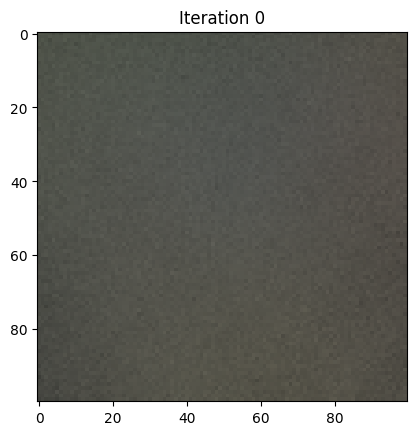

  1%|          | 50/5000 [00:24<38:38,  2.13it/s]

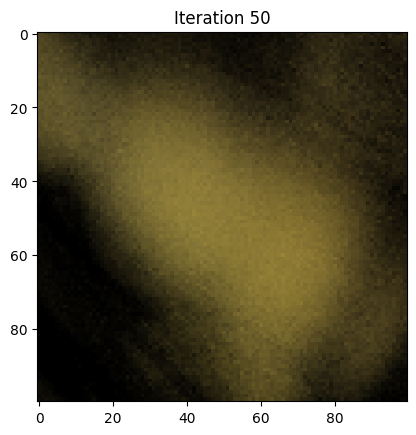

  2%|▏         | 100/5000 [00:47<35:47,  2.28it/s]

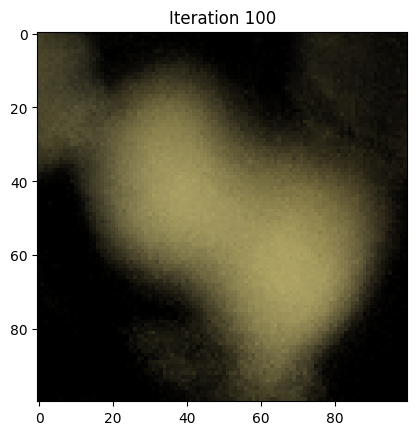

  3%|▎         | 150/5000 [01:10<35:31,  2.28it/s]

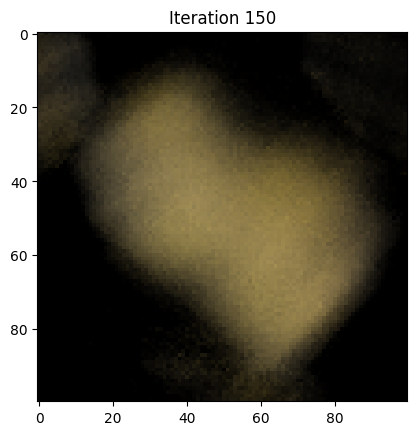

  4%|▍         | 200/5000 [01:34<35:04,  2.28it/s]

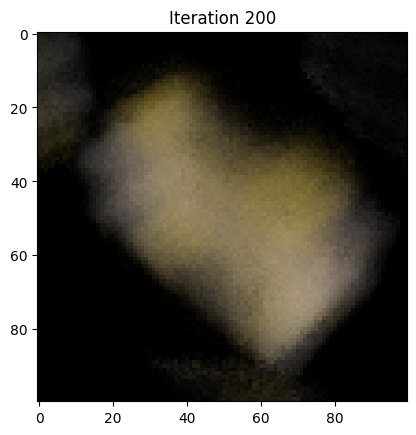

  5%|▌         | 250/5000 [01:57<34:46,  2.28it/s]

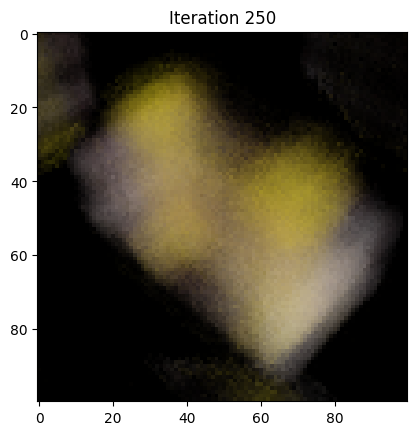

  6%|▌         | 300/5000 [02:20<34:31,  2.27it/s]

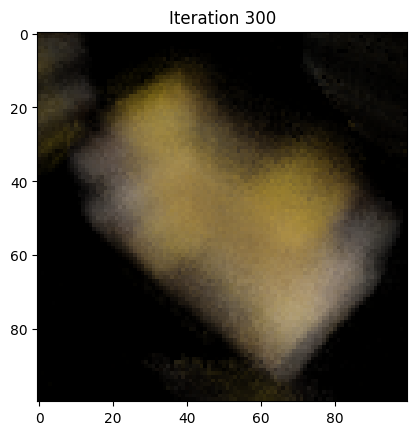

  7%|▋         | 350/5000 [02:44<34:23,  2.25it/s]

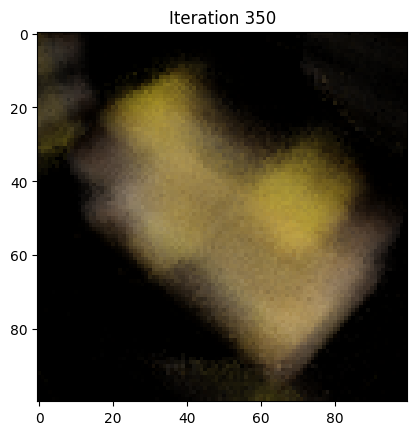

  8%|▊         | 400/5000 [03:08<33:45,  2.27it/s]

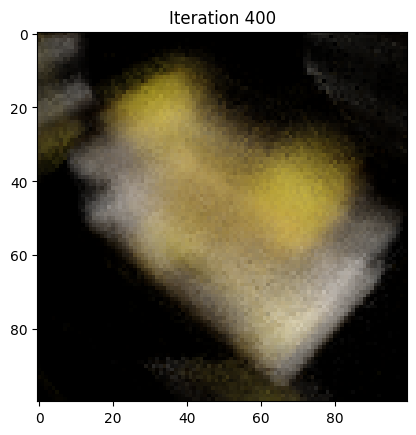

  9%|▉         | 450/5000 [03:31<33:29,  2.26it/s]

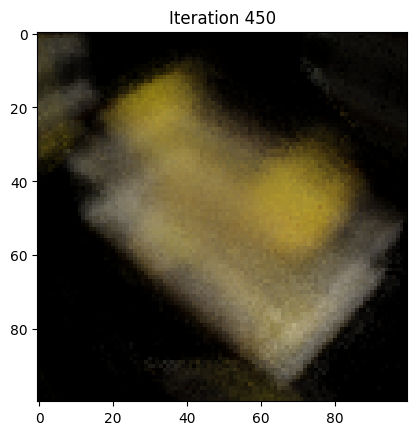

 10%|█         | 500/5000 [03:54<33:19,  2.25it/s]

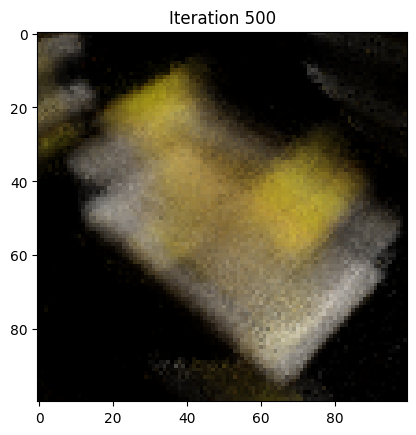

 11%|█         | 550/5000 [04:18<33:01,  2.25it/s]

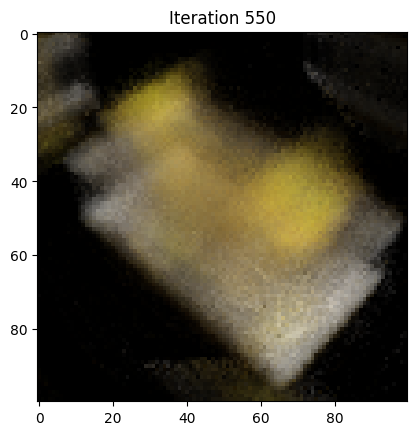

 12%|█▏        | 600/5000 [04:41<32:49,  2.23it/s]

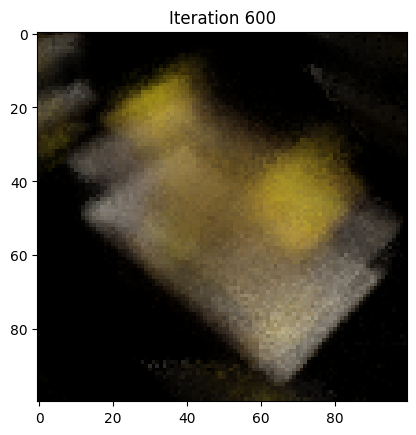

 13%|█▎        | 650/5000 [05:04<32:42,  2.22it/s]

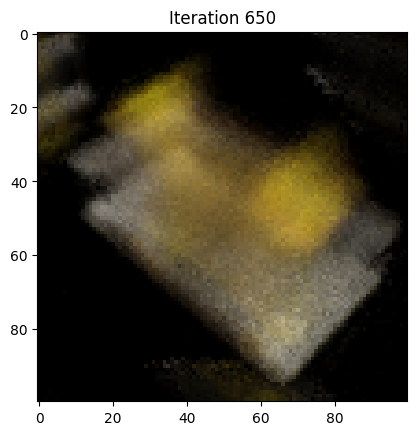

 14%|█▍        | 700/5000 [05:28<33:14,  2.16it/s]

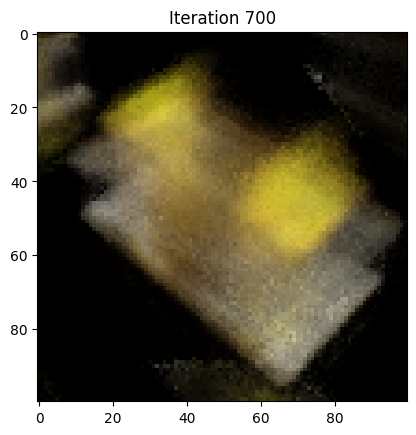

 15%|█▌        | 750/5000 [05:52<32:23,  2.19it/s]

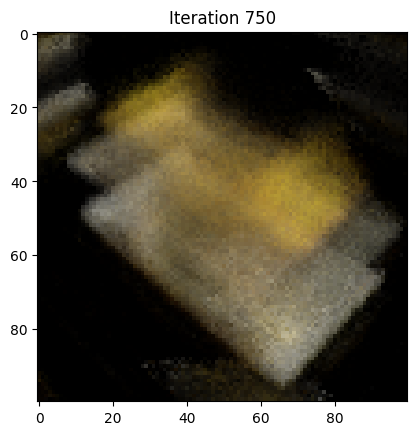

 16%|█▌        | 800/5000 [06:15<33:35,  2.08it/s]

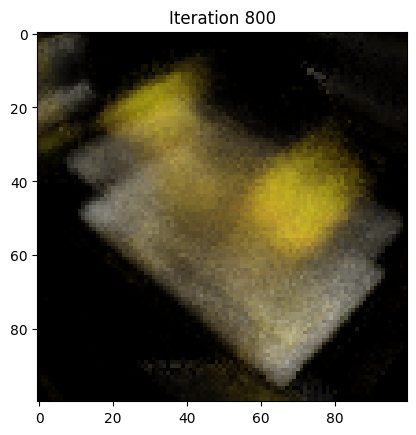

 17%|█▋        | 850/5000 [06:38<32:17,  2.14it/s]

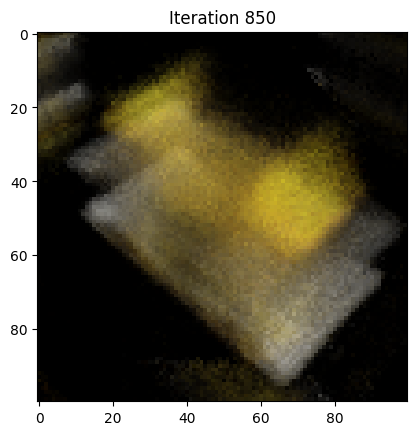

 18%|█▊        | 900/5000 [07:02<32:32,  2.10it/s]

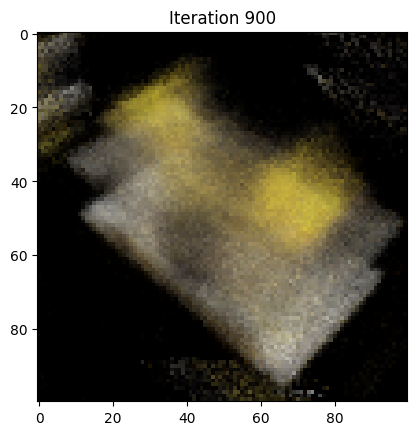

 19%|█▉        | 950/5000 [07:25<32:32,  2.07it/s]

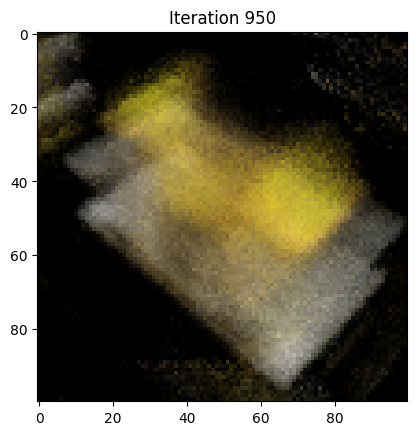

 20%|██        | 1000/5000 [07:48<32:59,  2.02it/s]

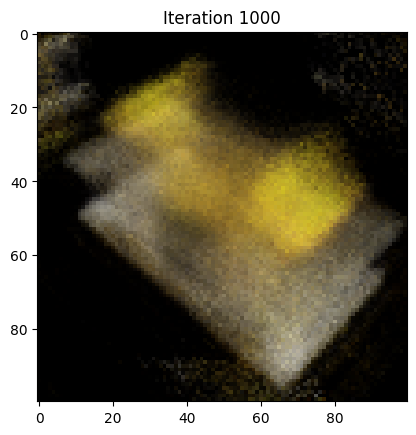

 21%|██        | 1050/5000 [08:12<40:55,  1.61it/s]

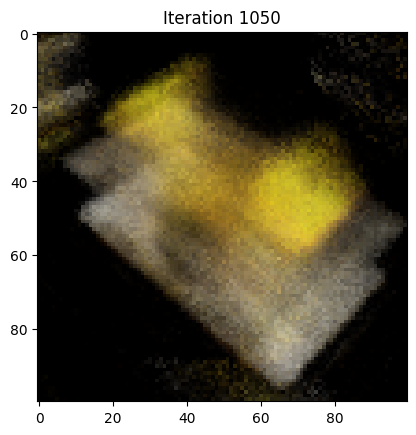

 22%|██▏       | 1100/5000 [08:36<34:45,  1.87it/s]

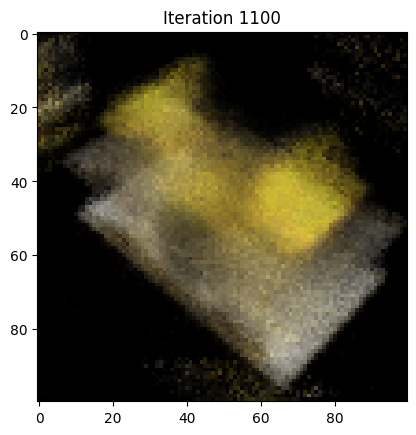

 23%|██▎       | 1150/5000 [08:59<33:36,  1.91it/s]

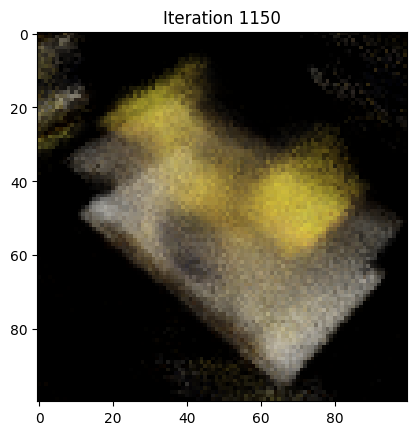

 24%|██▍       | 1200/5000 [09:22<30:59,  2.04it/s]

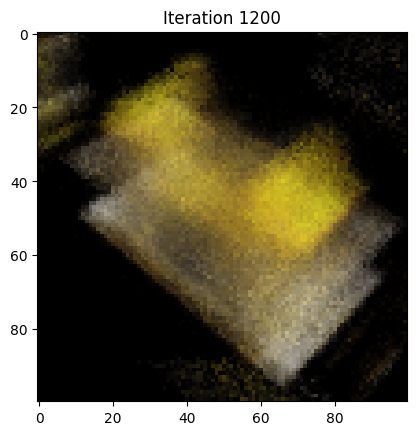

 25%|██▌       | 1250/5000 [09:46<30:16,  2.06it/s]

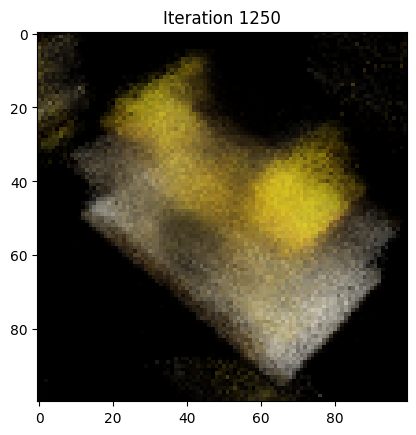

 26%|██▌       | 1300/5000 [10:09<28:03,  2.20it/s]

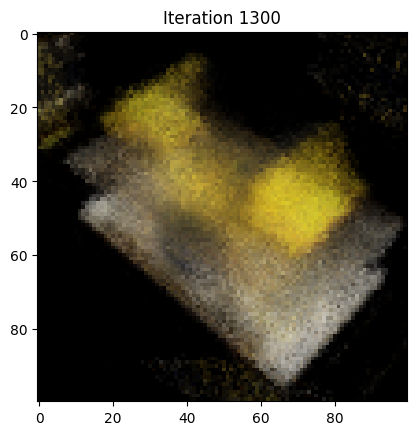

 27%|██▋       | 1350/5000 [10:32<26:49,  2.27it/s]

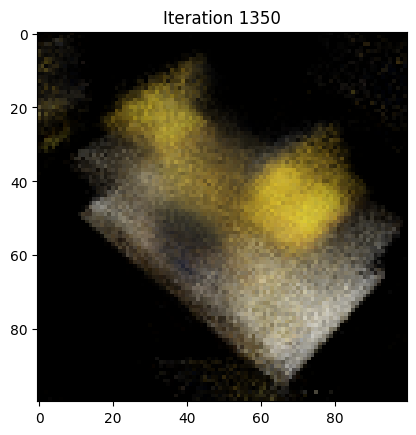

 28%|██▊       | 1400/5000 [10:56<26:29,  2.27it/s]

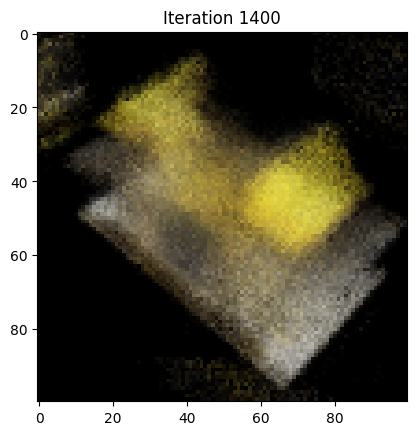

 29%|██▉       | 1450/5000 [11:20<26:10,  2.26it/s]

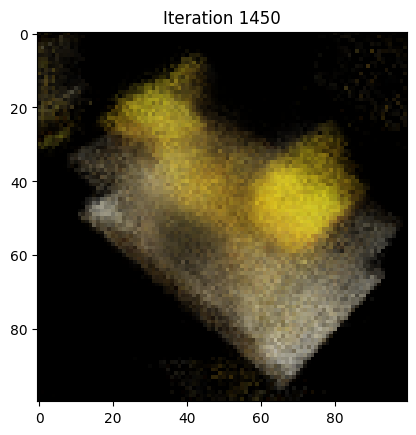

 30%|███       | 1500/5000 [11:43<25:44,  2.27it/s]

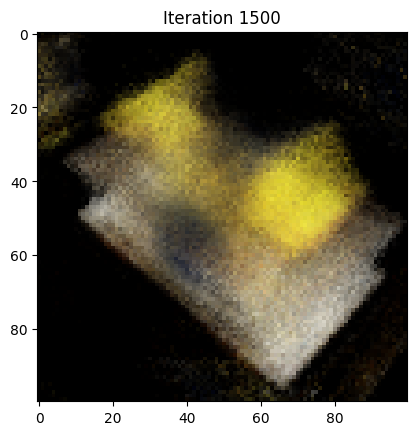

 31%|███       | 1550/5000 [12:07<25:16,  2.28it/s]

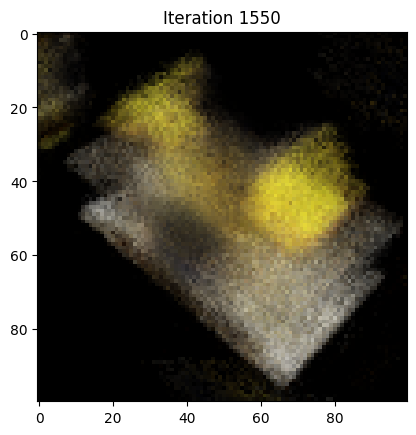

 32%|███▏      | 1600/5000 [12:30<25:02,  2.26it/s]

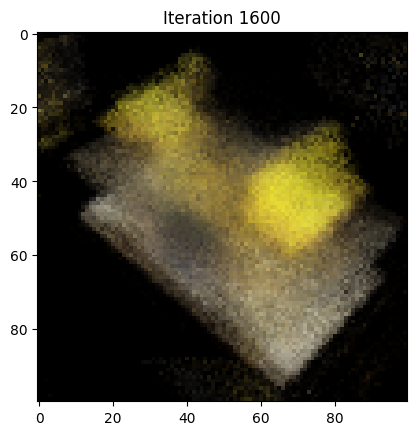

 33%|███▎      | 1650/5000 [12:54<24:48,  2.25it/s]

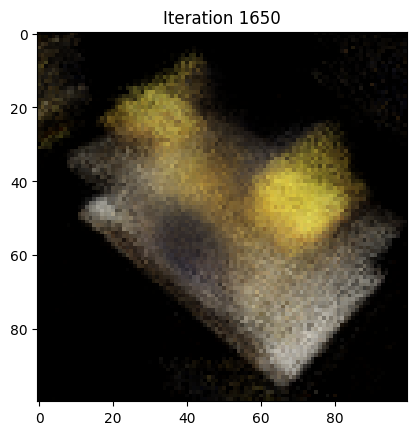

 34%|███▍      | 1700/5000 [13:17<24:07,  2.28it/s]

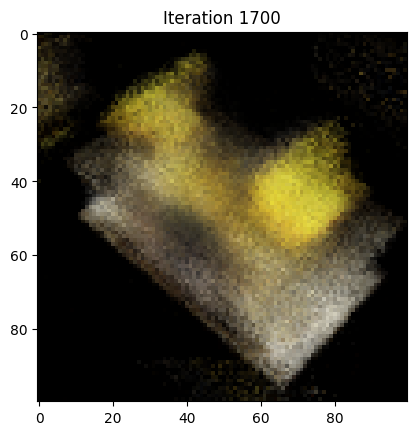

 35%|███▌      | 1750/5000 [13:41<23:59,  2.26it/s]

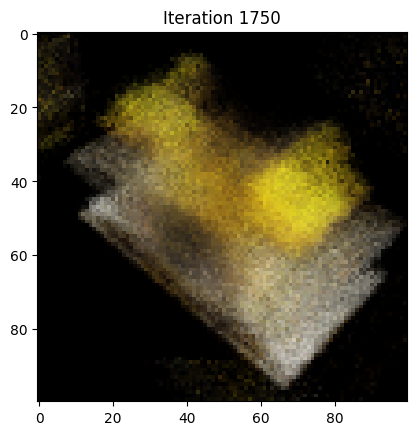

 36%|███▌      | 1800/5000 [14:05<23:48,  2.24it/s]

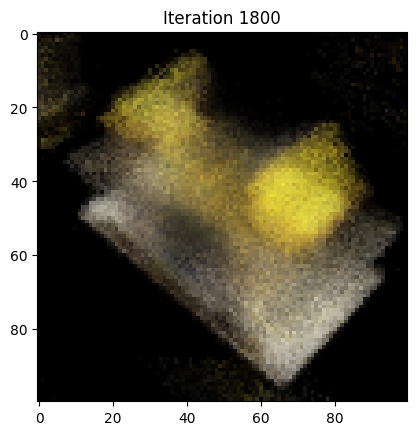

 37%|███▋      | 1850/5000 [14:28<23:10,  2.26it/s]

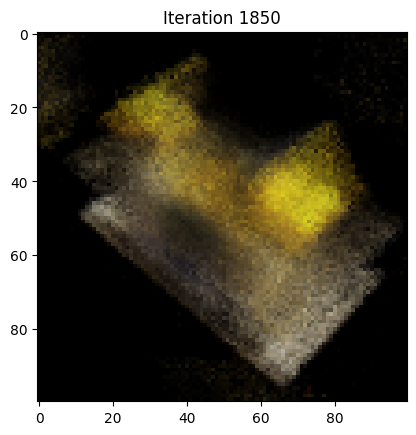

 38%|███▊      | 1900/5000 [14:52<22:56,  2.25it/s]

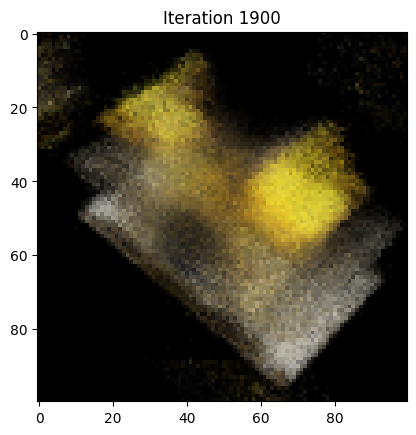

 39%|███▉      | 1950/5000 [15:15<22:25,  2.27it/s]

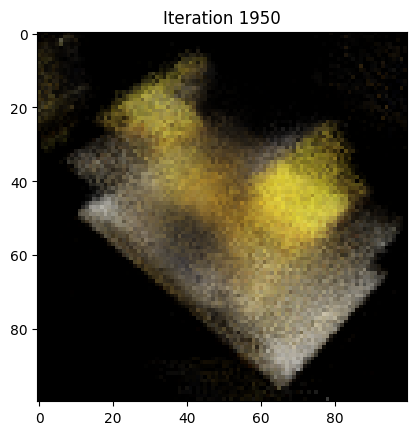

 40%|████      | 2000/5000 [15:38<22:43,  2.20it/s]

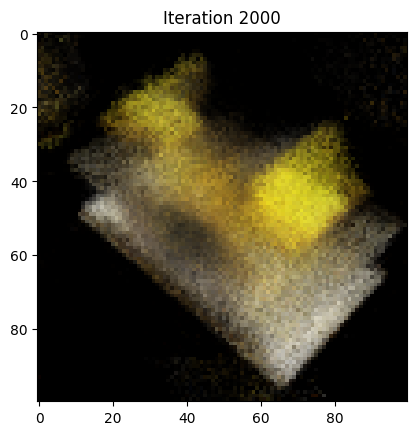

 41%|████      | 2050/5000 [16:02<21:55,  2.24it/s]

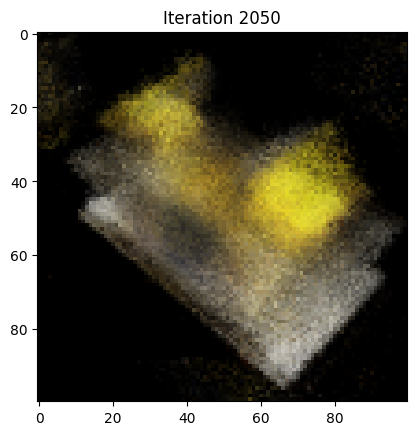

 42%|████▏     | 2100/5000 [16:26<21:28,  2.25it/s]

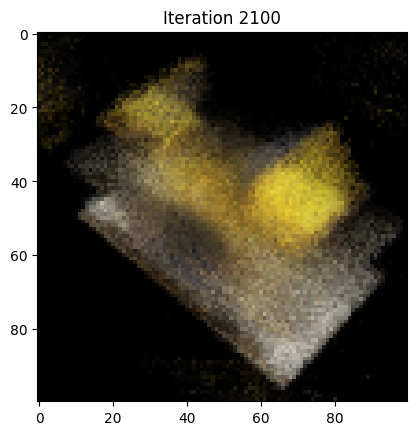

 43%|████▎     | 2150/5000 [16:50<21:05,  2.25it/s]

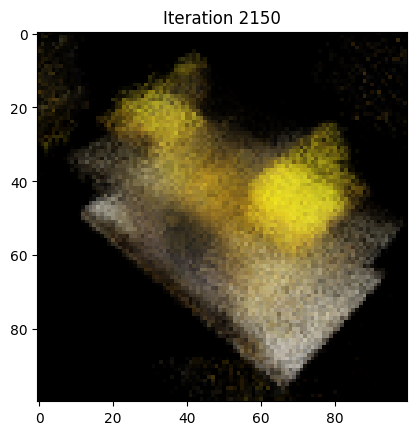

 44%|████▍     | 2200/5000 [17:13<20:45,  2.25it/s]

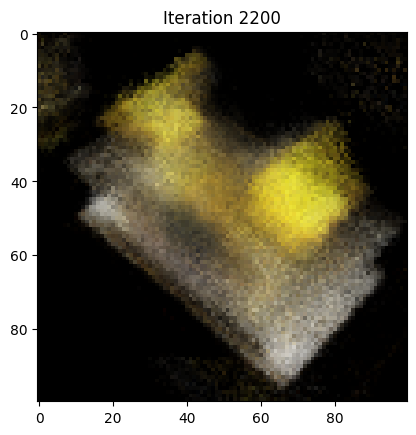

 45%|████▌     | 2250/5000 [17:37<20:14,  2.26it/s]

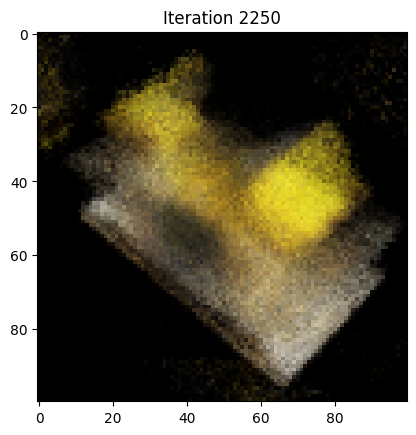

 46%|████▌     | 2300/5000 [18:00<19:51,  2.27it/s]

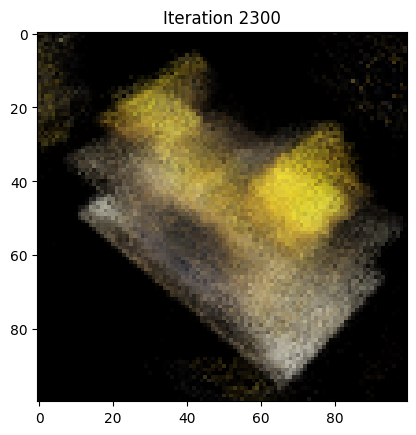

 47%|████▋     | 2350/5000 [18:24<19:35,  2.25it/s]

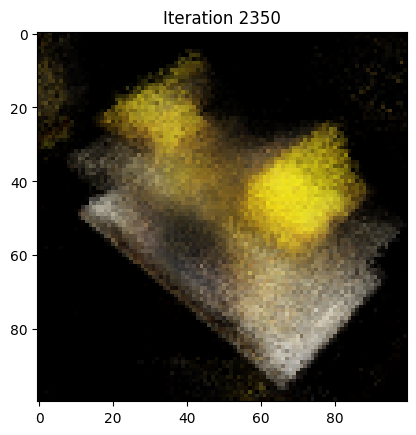

 48%|████▊     | 2400/5000 [18:48<19:12,  2.26it/s]

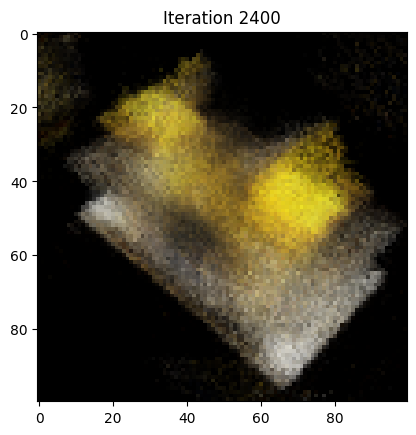

 49%|████▉     | 2450/5000 [19:11<18:53,  2.25it/s]

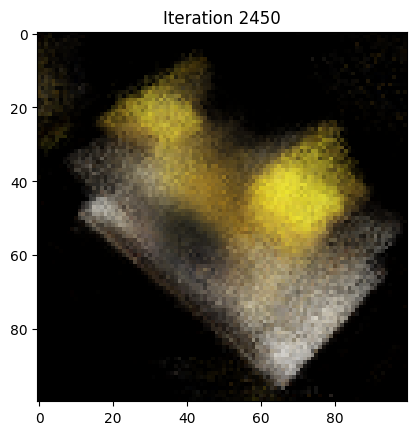

 50%|█████     | 2500/5000 [19:35<18:36,  2.24it/s]

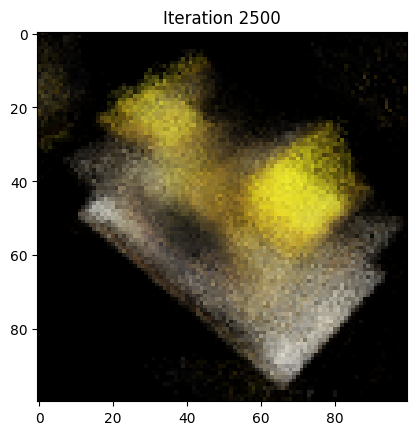

 51%|█████     | 2550/5000 [19:59<18:06,  2.25it/s]

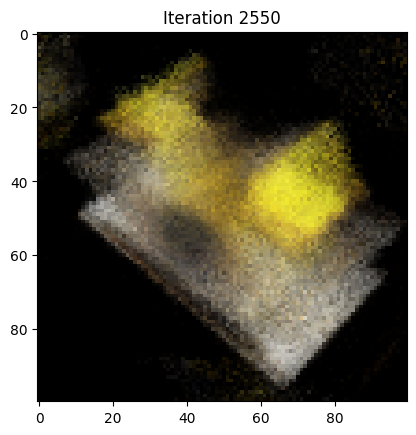

 52%|█████▏    | 2600/5000 [20:22<17:45,  2.25it/s]

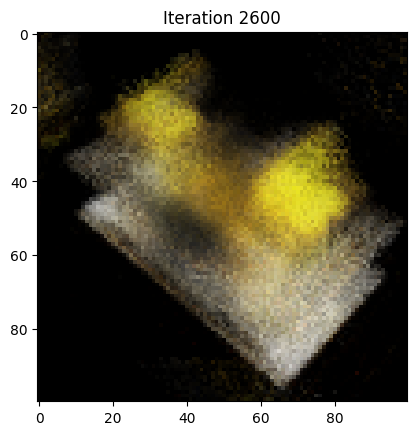

 53%|█████▎    | 2650/5000 [20:46<17:19,  2.26it/s]

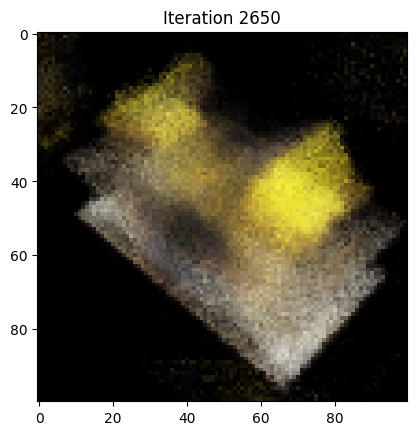

 54%|█████▍    | 2700/5000 [21:09<17:24,  2.20it/s]

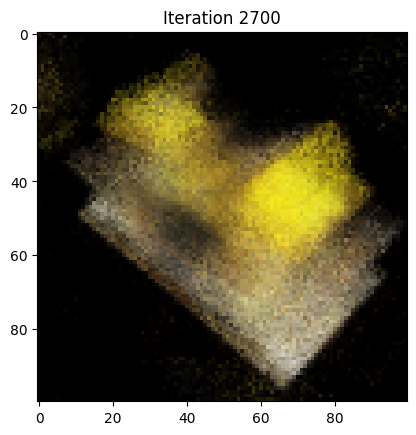

 55%|█████▌    | 2750/5000 [21:33<16:46,  2.24it/s]

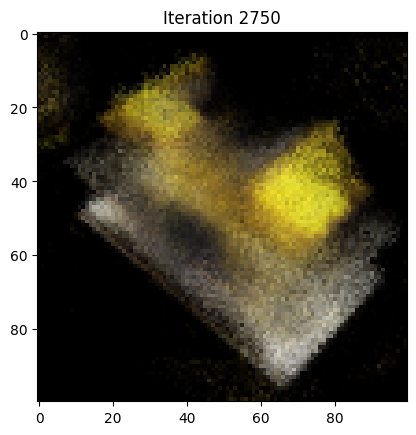

 56%|█████▌    | 2800/5000 [21:56<16:25,  2.23it/s]

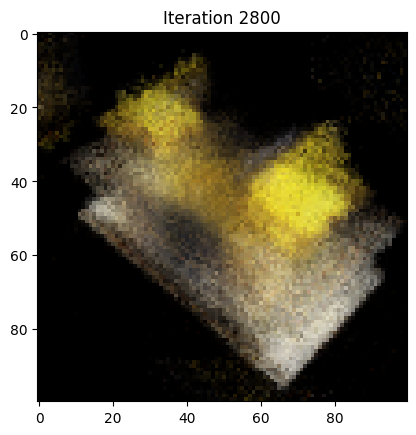

 57%|█████▋    | 2850/5000 [22:20<16:40,  2.15it/s]

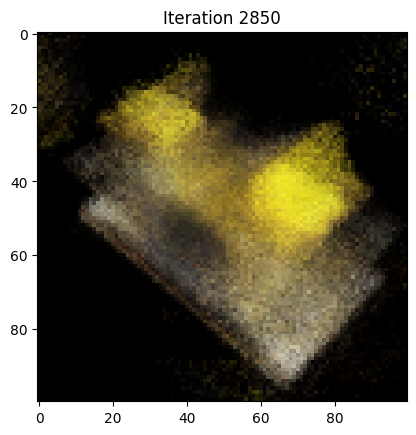

 58%|█████▊    | 2900/5000 [22:44<16:01,  2.18it/s]

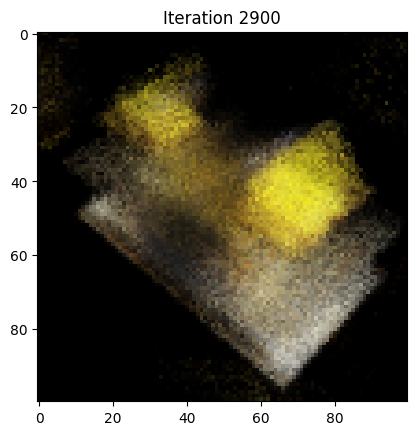

 59%|█████▉    | 2950/5000 [23:08<15:14,  2.24it/s]

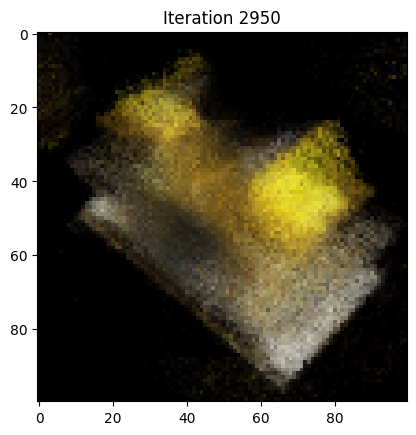

 60%|██████    | 3000/5000 [23:31<14:51,  2.24it/s]

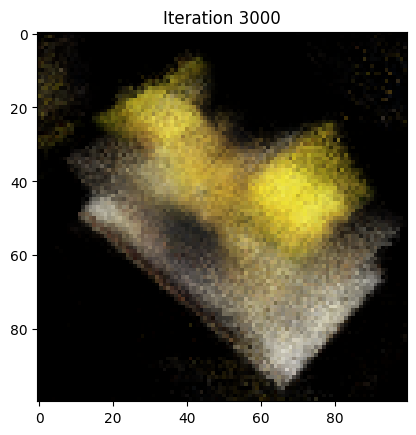

 61%|██████    | 3050/5000 [23:54<14:36,  2.23it/s]

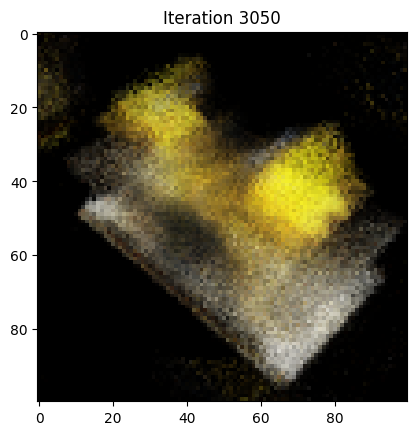

 62%|██████▏   | 3100/5000 [24:18<14:11,  2.23it/s]

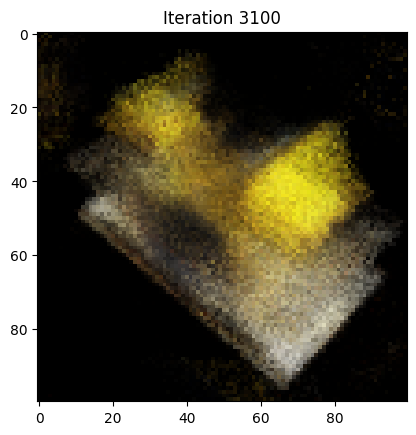

 63%|██████▎   | 3150/5000 [24:42<13:55,  2.21it/s]

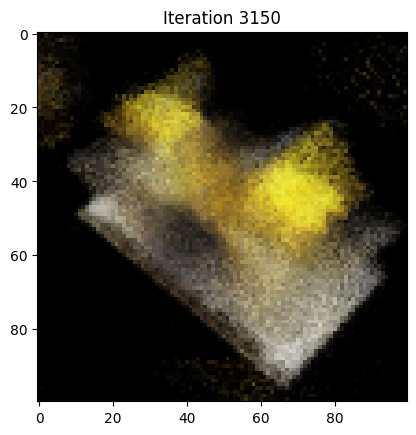

 64%|██████▍   | 3200/5000 [25:05<13:38,  2.20it/s]

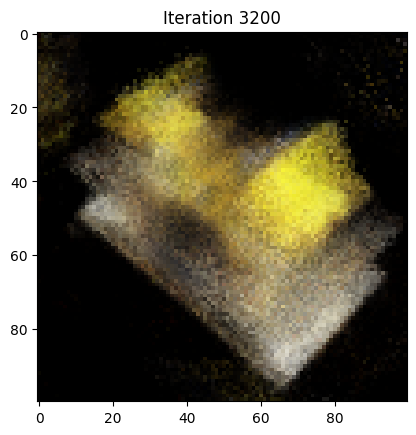

 65%|██████▌   | 3250/5000 [25:29<13:07,  2.22it/s]

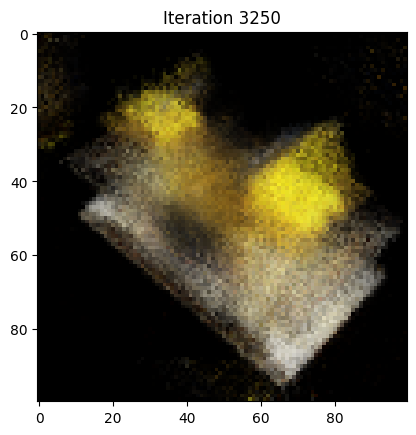

 66%|██████▌   | 3300/5000 [25:53<12:44,  2.22it/s]

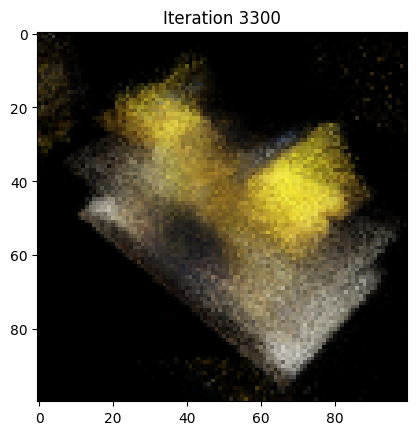

 67%|██████▋   | 3350/5000 [26:17<12:31,  2.19it/s]

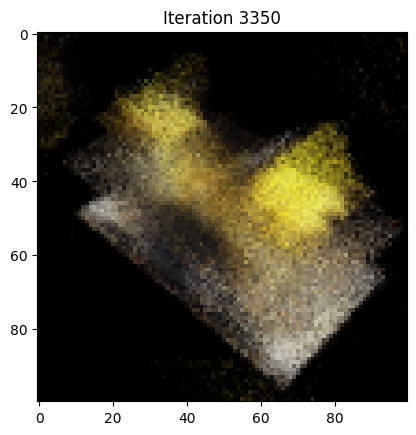

 68%|██████▊   | 3400/5000 [26:40<12:18,  2.17it/s]

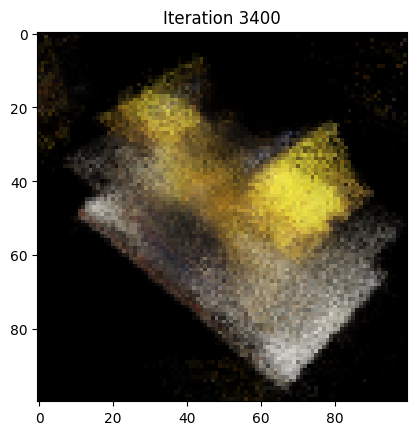

 69%|██████▉   | 3450/5000 [27:03<11:51,  2.18it/s]

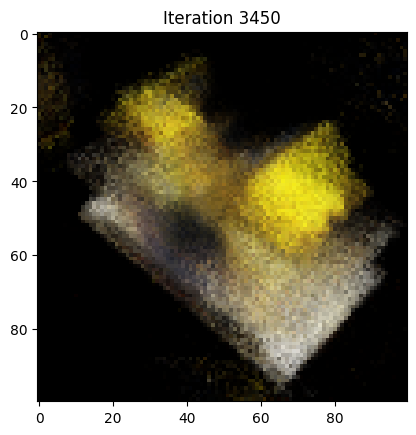

 70%|███████   | 3500/5000 [27:27<11:35,  2.16it/s]

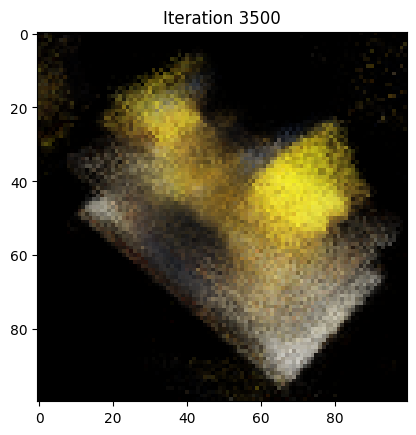

 71%|███████   | 3550/5000 [27:51<11:15,  2.15it/s]

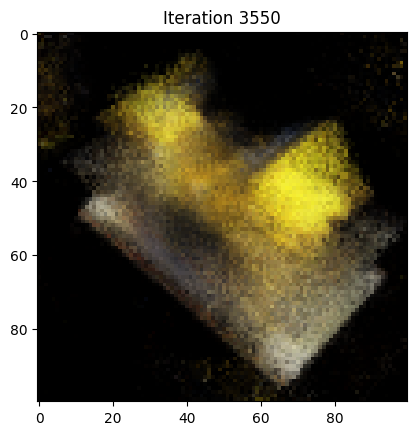

 72%|███████▏  | 3600/5000 [28:15<11:09,  2.09it/s]

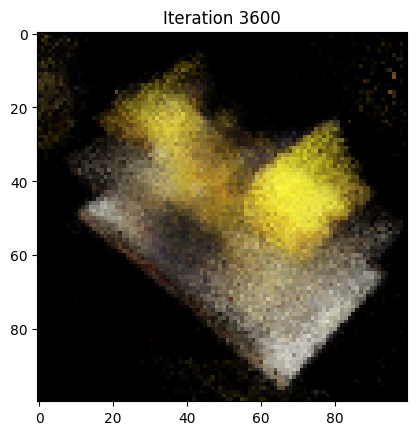

 73%|███████▎  | 3650/5000 [28:38<11:04,  2.03it/s]

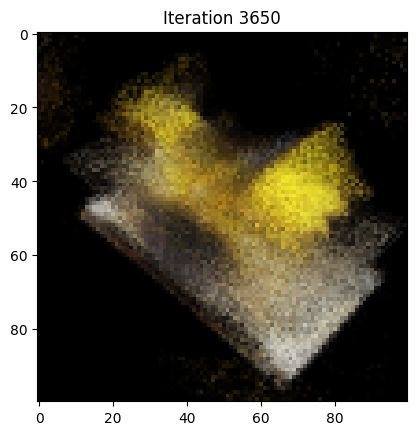

 74%|███████▍  | 3700/5000 [29:02<10:49,  2.00it/s]

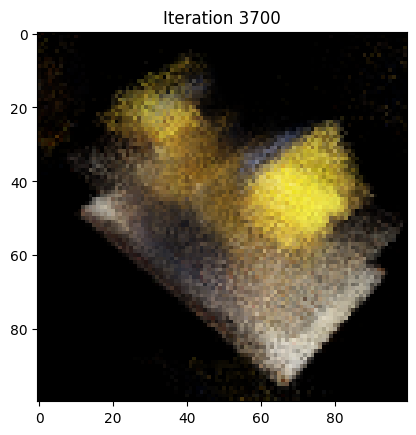

 75%|███████▌  | 3750/5000 [29:26<10:24,  2.00it/s]

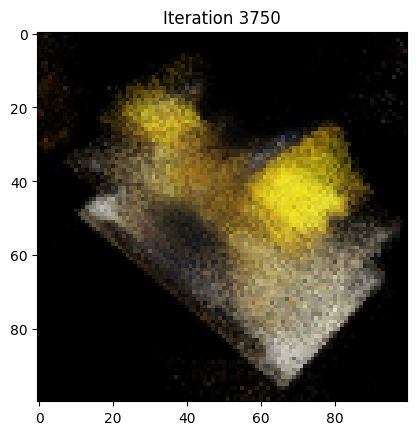

 76%|███████▌  | 3800/5000 [29:50<10:19,  1.94it/s]

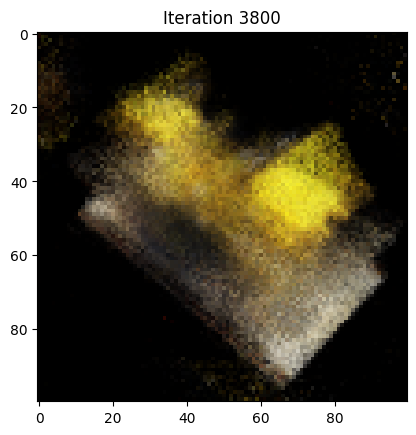

 77%|███████▋  | 3850/5000 [30:13<10:06,  1.90it/s]

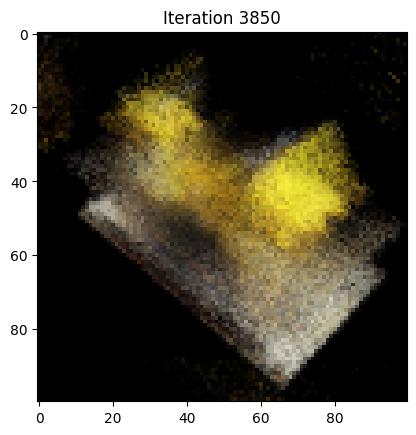

 78%|███████▊  | 3900/5000 [30:37<09:55,  1.85it/s]

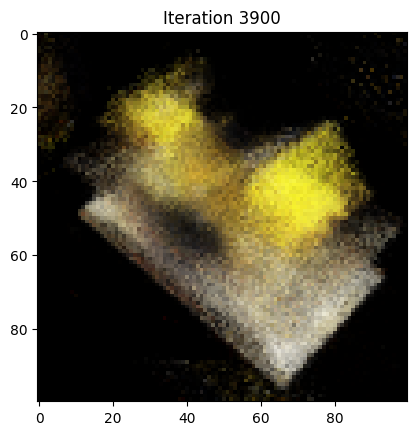

 79%|███████▉  | 3950/5000 [31:01<09:17,  1.88it/s]

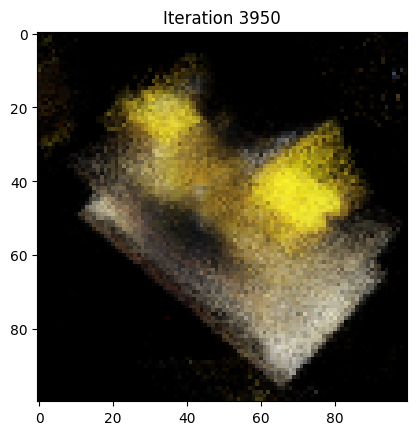

 80%|████████  | 4000/5000 [31:24<09:00,  1.85it/s]

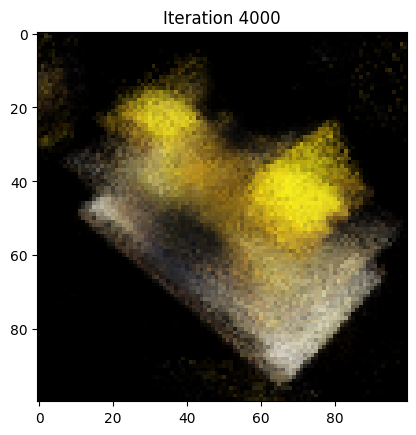

 81%|████████  | 4050/5000 [31:48<07:58,  1.99it/s]

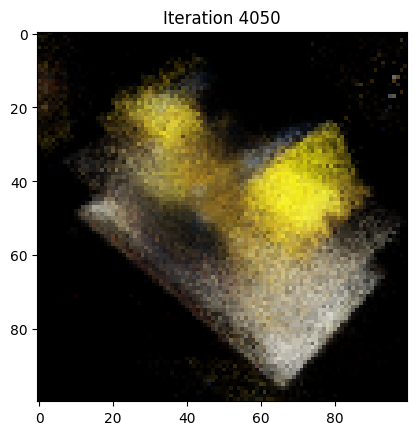

 82%|████████▏ | 4100/5000 [32:11<07:25,  2.02it/s]

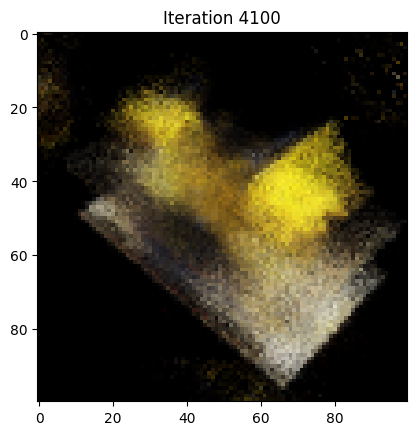

 83%|████████▎ | 4150/5000 [32:35<06:52,  2.06it/s]

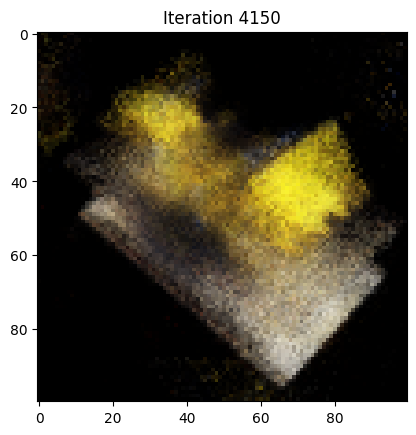

 84%|████████▍ | 4200/5000 [32:58<06:10,  2.16it/s]

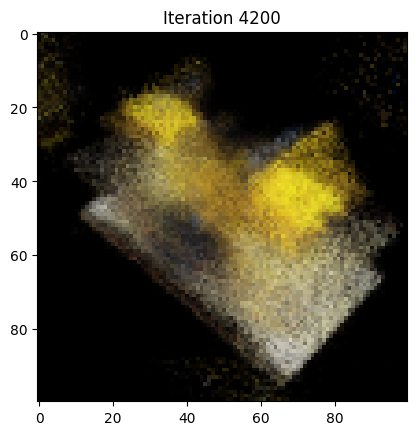

 85%|████████▌ | 4250/5000 [33:22<05:31,  2.26it/s]

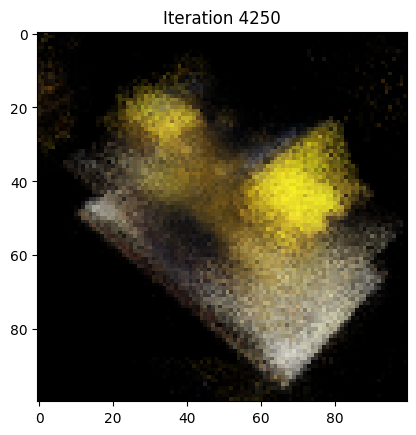

 86%|████████▌ | 4300/5000 [33:46<05:42,  2.04it/s]

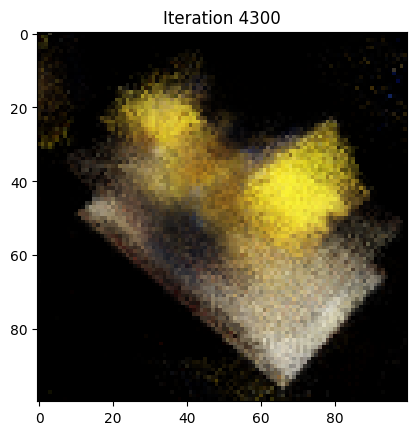

 87%|████████▋ | 4350/5000 [34:09<04:48,  2.25it/s]

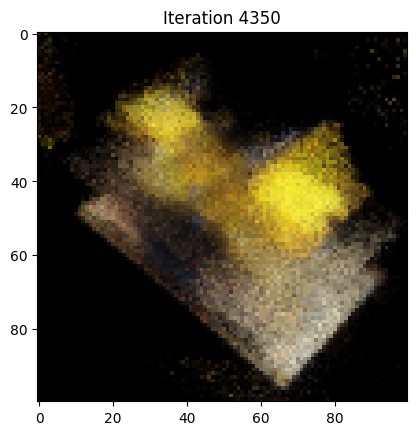

 88%|████████▊ | 4400/5000 [34:33<04:29,  2.22it/s]

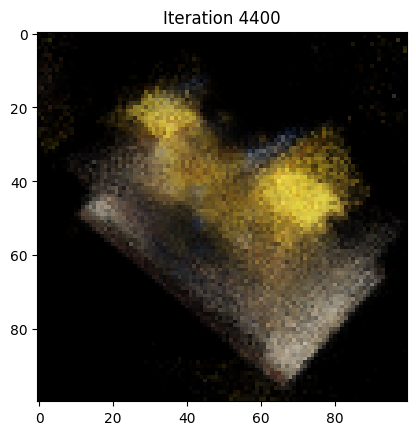

 89%|████████▉ | 4450/5000 [34:57<04:06,  2.23it/s]

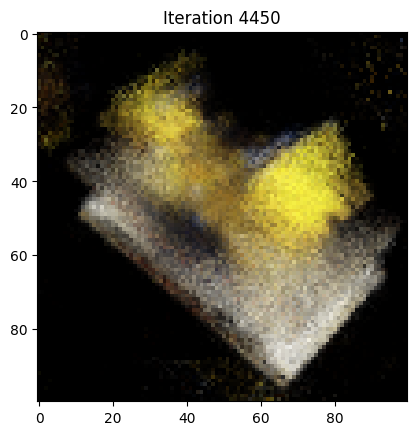

 90%|█████████ | 4500/5000 [35:20<03:40,  2.26it/s]

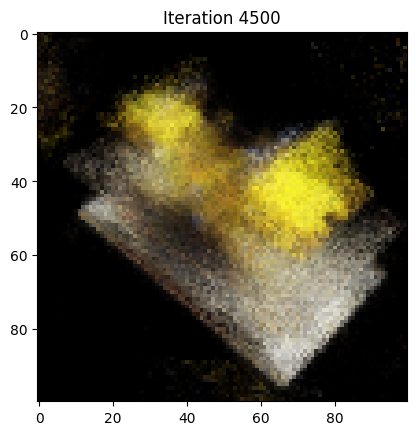

 91%|█████████ | 4550/5000 [35:44<03:18,  2.27it/s]

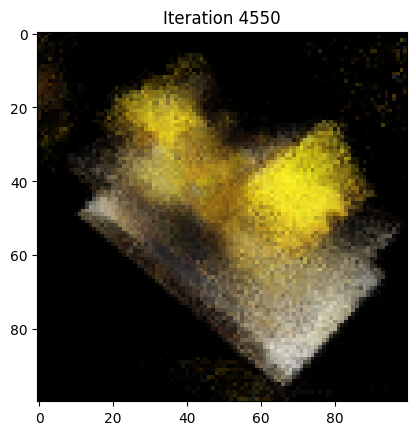

 92%|█████████▏| 4600/5000 [36:08<02:57,  2.26it/s]

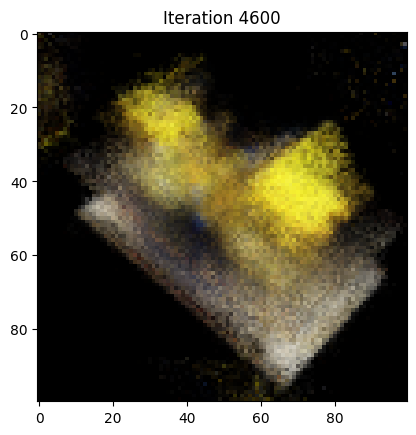

 93%|█████████▎| 4650/5000 [36:31<02:34,  2.27it/s]

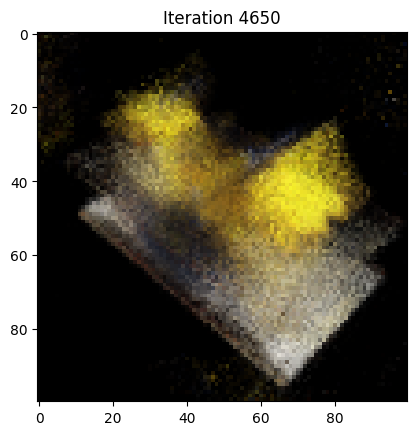

 94%|█████████▍| 4700/5000 [36:55<02:12,  2.26it/s]

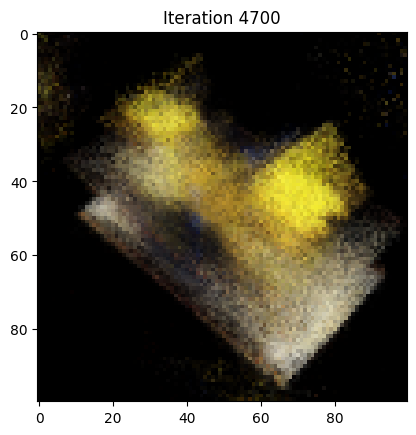

 95%|█████████▌| 4750/5000 [37:18<01:50,  2.27it/s]

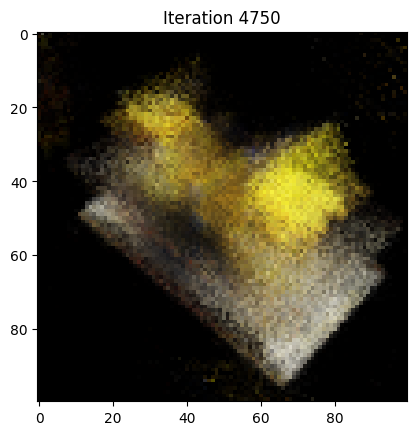

 96%|█████████▌| 4800/5000 [37:42<01:33,  2.14it/s]

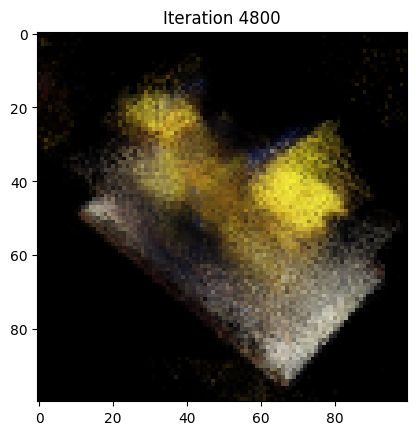

 97%|█████████▋| 4850/5000 [38:05<01:06,  2.27it/s]

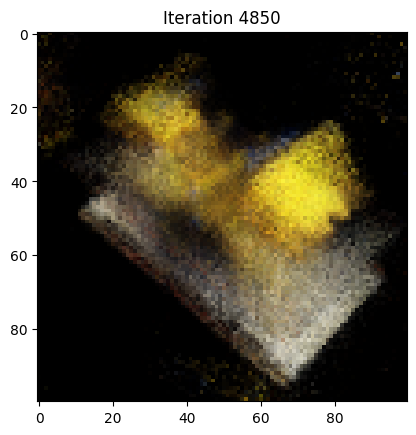

 98%|█████████▊| 4900/5000 [38:28<00:44,  2.26it/s]

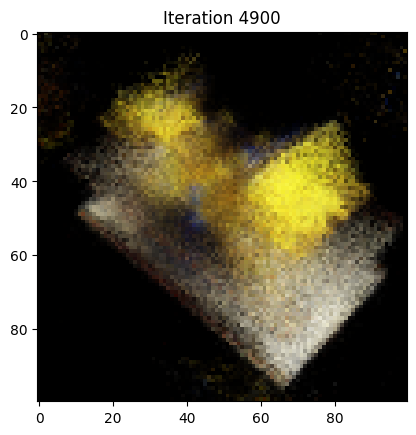

 99%|█████████▉| 4950/5000 [38:52<00:21,  2.27it/s]

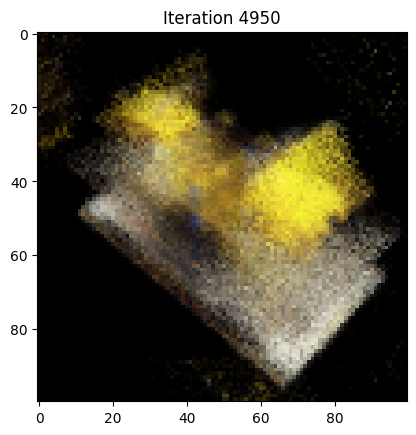

100%|██████████| 5000/5000 [39:15<00:00,  2.12it/s]


In [ ]:
# Training module
num_pos_encoding_functions = 16
num_dir_encoding_functions = 4
num_coarse_samples_per_ray = 32
num_fine_samples_per_ray = 32
near_thresh = 2.0 # set based on data
far_thresh = 6.0 # set based on data
include_input_in_posenc = False
include_input_in_direnc = False
is_ndc_required = False # set to True only for forward facing scenes
use_viewdirs = True

num_epochs = 5000
batch_size = 1 # TODO: why not have more images in batch
chunk_size = 4096 # because 4096 for 1.2GB of GPU memory
validate_every = 50
num_random_rays = 0

model = NeRF(num_pos_encoding_functions, num_dir_encoding_functions, use_viewdirs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

for epoch in tqdm(range(num_epochs)):

  # Pick one random sample for training
  index = np.random.randint(len(images)) #TODO: check if it is without replacement
  target_img = images[index].to(device)
  target_img = target_img.reshape(-1, 3)
  training_campose = poses[index].to(device)

  # Call NeRF
  rgb_coarse, rgb_fine = run_nerf_mip(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, False,
                                  near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
                                  include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
                                  num_dir_encoding_functions, model, chunk_size, num_random_rays, mode='train')
  # print(rgb_coarse[0], rgb_fine[0])
  # rgb_coarse, rgb_fine, selected_rays_ind = run_nerf(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, False,
  #                                 near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
  #                                 include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
  #                                 num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode='train')

  # if num_random_rays > 0:
  #   target_img = target_img[selected_rays_ind, :]

  # Compute total loss - coarse + fine
  coarse_loss = torch.nn.functional.mse_loss(rgb_coarse, target_img)
  fine_loss = torch.nn.functional.mse_loss(rgb_fine, target_img)
  total_loss = coarse_loss+fine_loss  #TODO - why summing it ?

  # Backpropagate
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # Evaluation for every few epochs on test pose
  if epoch % validate_every ==0:
    rgb_test_coarse, rgb_test_fine = run_nerf_mip(height, width, focal_length, test_pose, use_viewdirs, is_ndc_required, False,
                                                 near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
                                                 include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
                                                 num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode='eval')
    fig = plt.figure()
    rgb_test_fine = rgb_test_fine.reshape(height, width, 3)
    plt.imshow(rgb_test_fine.detach().cpu().numpy())
    plt.title(f"Iteration {epoch}")
    plt.show()